# Hit-Predict project: Predicting a song's popularity using Spotify data

## Problem Statement

Predicting a song's popularity is mutually beneficial for both the industry and its consumers. Record labels and streaming platforms are interested in which songs to promote and prioritize, and consumers want to discover songs they connect with and enjoy. This project therefore seeks to answer the question: **What factors most strongly influence a song's popularity, and how can they be leveraged to accurately predict it?**

This project focuses on predicting the popularity of songs from the streaming service Spotify based on audio features, artist information, and other relevant metadata. The goal is to build a model and that provides robust predictions on the popularity of songs. 

Predicting track popularity requires analyzing patterns in song attributes to understand its influences. Key features to consider include song characteristics like danceability, energy, loudness, and genre. 

The challenge with predicting popularity is that popularity distribution is heavily skewed; in other words, not many songs become hits. Particularly with streaming services, it is easy to upload your own songs which results in many tracks having zero popularity. This imbalanced distribution may introduce bias in training models if not handled appropriately.

To accompany our popularity prediction, we aim to create a recommendation system that takes a song a user enjoys, and suggests similar songs. As songs often have numerous overlapping characteristics, a challenge in this area is clearly defining what makes songs similar.

<div style="text-align: center;">
    <h3>Model Flow Chart</h3>
    <img src="../images/flow chart image.png" alt="Image Example" style="width: 50%;">
</div>

## Table of Contents
1. [Setup](#setup)
    - [Importing Libraries](#lib)
    - [Loading Data](#data)
2. [EDA](#eda)
3. [Baseline Models](#baseline)
    - [Regression Baseline Model](#sub1)
    - [Classification Baseline Model (using 3 levels)](#sub2)
        - [Decision Tree](#subclass1)
        - [Logistic Regression](#subclass2)
4. [Classification Model Pipeline](#pipeline)
5. [Classification Model Building](#classification)
    - [Fine-tuned Decision Tree](#finetuned)
    - [Random Forest](#forest)
    - [Gradient Boosting](#gradient)
    - [XGBoost](#xgb)
    - [Blending and Stacking](#blendingstacking)
6. [Model Results](#results)
    - [Feature Importance](#featureimportance)
    - [Limitations and Future Directions](#limitations)
7. [Recommendation System](#recommendation)
    - [K-Means Clustering](#kmeans)
    - [Content-based Filtering](#content)
    - [Analysis and Future Direction](#analysis)

## 1. Setup
<a id="setup"></a>

### Importing Libraries
<a id="lib"></a>

In [201]:
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, GridSearchCV,  StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.inspection import permutation_importance
from xgboost import XGBClassifier
from sklearn.metrics import r2_score
from scipy.stats import zscore
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import VotingClassifier, StackingClassifier
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)

ModuleNotFoundError: No module named 'xgboost'

### Loading Data
<a id="data"></a>

Loading three dataframes, each of which encode the imbalanced data in different ways. We will explore this imbalance in our EDA and decide which encoding works best for our model in the baseline modeling section.

In [202]:
DATA_PATH_nothing = "../data/processed_spotify_songs.csv"
df_nothing = pd.read_csv(DATA_PATH_nothing)

DATA_PATH_0mean = "../data/0mean_data.csv"
df_0mean = pd.read_csv(DATA_PATH_0mean)

DATA_PATH_no0 = "../data/no0_data.csv"
df_no0 = pd.read_csv(DATA_PATH_no0)

We drop columns that we applied target encoding to and resaved, or that we one-hot encoded that were needed for EDA and other pre-processing steps in previous milestones. 

We also ended up dropping `playlist_id_encoded` and `track_album_id_encoded` here as we discovered during our modeling process that it encoded very similar information to the outcome variable, `track_popularity`. When utilizing the training and test datasets, we found that since these variables are unique identifiers of existing music, the model utilized this piece of information to predict the popularity very accurately. However, this would not work if we were to predict the popularity of a new song which does not already have an existing track album ID which the model was trained on. Therefore, the high F1 and accuracies scores that resulted from initially including this variable were artificially inflated and did not reflect how well the model would generalize. Although removing the variables resulted in the model F1 score decreasing, it was necessary to ensure that the model does not overfit to the training and test data, and that we can accurately understand how the model is performing.

In [203]:
df_nothing = df_nothing.drop(columns=["track_artist", "track_album_id","track_album_release_date","playlist_id","playlist_subgenre","track_album_id_encoded","playlist_id_encoded"])
df_0mean = df_0mean.drop(columns=["track_artist", "track_album_id","track_album_release_date","playlist_id","playlist_subgenre","track_album_id_encoded","playlist_id_encoded"])
df_no0 = df_no0.drop(columns=["track_artist", "track_album_id","track_album_release_date","playlist_id","playlist_subgenre","track_album_id_encoded","playlist_id_encoded"])

## 2. Explore and visualize the data
<a id="eda"></a>

We will conduct exploratory data analysis to understand the underlying trends in the data using the pre-processed data. As discussed in the problem statement, the data is inherently skewed. Alongside exploring the variables, we will visualize this skewness, as well as various different ways to deal with this imbalance in the data.

### Exploration of Variables
<a id="sub1"></a>

**Categorical variables:** artist_track_encoded, key, pop, hip hop, metal, rock, edm, r&b, latin

**Quantitative variables:** track_popularity, danceability, energy, loudness, mode, speechiness, acousticness, instrumentalness, liveness, valence, tempo, duration_ms, release_year, release_month, release_day

Here, artist_track_encoded encodes the popularity of a given artist's existing music.

In [5]:
df_nothing.describe().T

,count,mean,std,min,25%,50%,75%,max
track_popularity,28351.0,39.336708,23.698710,0.000000,21.000000,42.000000,58.000000,100.000000
danceability,28351.0,0.463804,0.188292,0.006152,0.325701,0.464561,0.597751,1.000000
energy,28351.0,0.521413,0.238350,0.000000,0.335241,0.521284,0.710649,1.000000
key,28351.0,5.367571,3.613714,0.000000,2.000000,6.000000,9.000000,11.000000
loudness,28351.0,0.699168,0.099018,0.000000,0.645119,0.714462,0.769371,1.000000
mode,28351.0,0.565518,0.495698,0.000000,0.000000,1.000000,1.000000,1.000000
speechiness,28351.0,0.453664,0.127324,0.290047,0.354797,0.408549,0.525214,1.000000
acousticness,28351.0,0.449822,0.248605,0.011209,0.243494,0.431212,0.639532,1.000000
instrumentalness,28351.0,0.175039,0.289071,0.000000,0.000000,0.027512,0.187717,1.000000
liveness,28351.0,0.544510,0.131376,0.211027,0.453020,0.503325,0.629961,1.000000


#### Distribution of the Target Variable (Track Popularity)

The target variable, `track_popularity`, is skewed and has many zero values. These zero values indicate songs with no popularity on the platform. Handling these variables is appropriately is important to avoid bias. In the plot below, we can see the distribution of `track_popularity` when the skewness is being handled in three different ways. 

The plot the left-hand side displays the distribution of `track_popularity` if we were to make no changes. This plot demonstrates the skewness present in the target variable before any transformations.

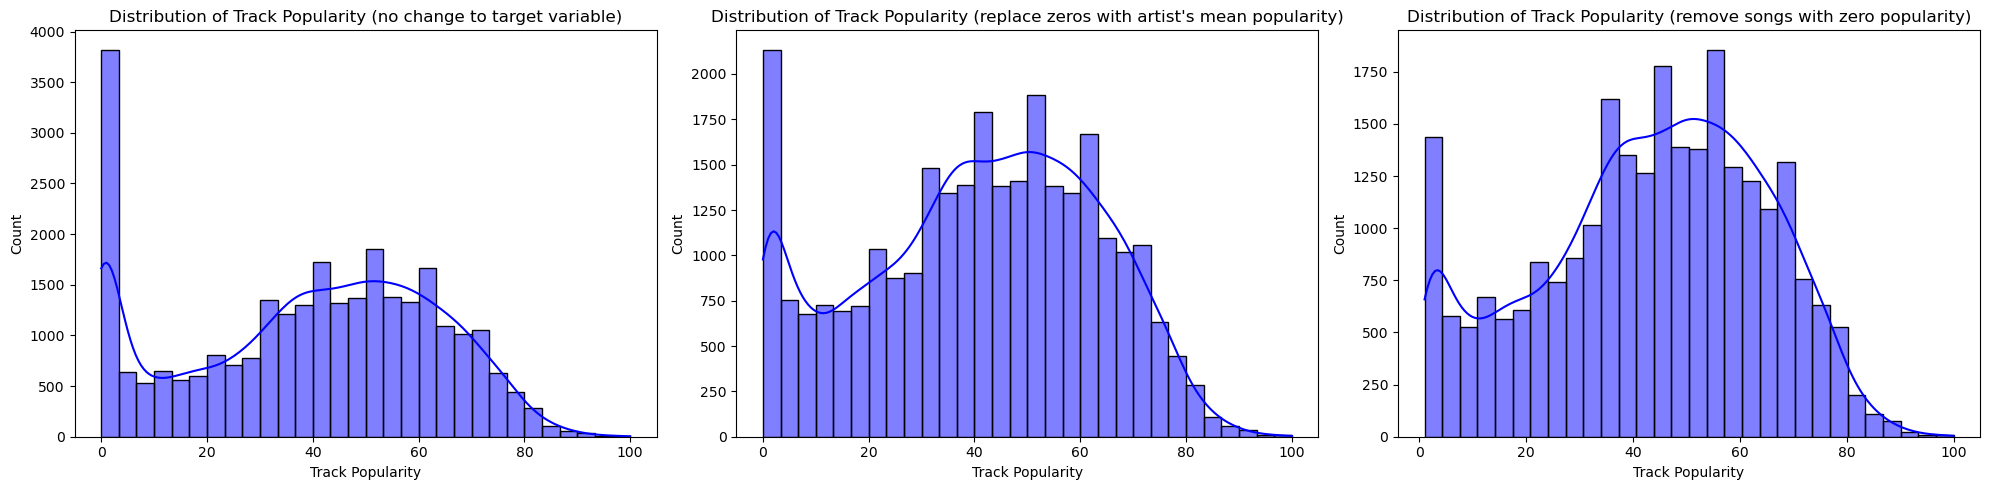

In [6]:
# plot histogram of track popularity for different ways of handling zero values
fig, axes = plt.subplots(1, 3, figsize=(20, 5)) # 3 rows 1 column

sns.histplot(df_nothing["track_popularity"], bins=30, kde=True, color='blue', ax=axes[0])
axes[0].set_title("Distribution of Track Popularity (no change to target variable)")
axes[0].set_xlabel("Track Popularity")
axes[0].set_ylabel("Count")

sns.histplot(df_0mean["track_popularity"], bins=30, kde=True, color='blue', ax=axes[1])
axes[1].set_title("Distribution of Track Popularity (replace zeros with artist's mean popularity)")
axes[1].set_xlabel("Track Popularity")
axes[1].set_ylabel("Count")

sns.histplot(df_no0["track_popularity"], bins=30, kde=True, color='blue', ax=axes[2])
axes[2].set_title("Distribution of Track Popularity (remove songs with zero popularity)")
axes[2].set_xlabel("Track Popularity")
axes[2].set_ylabel("Count")

plt.tight_layout()
plt.show()

Each of the plots above show the resulting distribution of the plots when considering three different ways to handle the large number of zero popularity tracks:
- Retain zero-popularity values as they are, with no transformation 
- Replace zero values with the artist’s mean popularity (excluding songs with zero popularity, unless all songs have zero)
- Remove all zero-popularity songs from the dataset

As we can see from the plots above, the second and third options reduce the skew. When replacing zeros with the artist's mean popularity, some zero values still remain, demonstrating that there are numerous artists where all their songs have zero popularity.

When removing all the zero popularity songs, we see that the next bin also has a lot of values representing songs with very low popularity. This again is not ideal and we might need to account for this in our analysis. When considering this option, we want to keep in mind that the ideal situation would be to have a normal distribution of the track popularity values.

We will consider all three of these options in our baseline model to understand the impact of each on the models.

#### Distribution of the numeric predictor variables

In the data pre-processing, we scaled and corrected the skewness of the quantitative variables. We can see their resulting distributions in the plots below.

Although several predictors including `instrumentalness` and `speechiness` remain imbalanced after scaling, the majority of predictors now follow a normal distribution. 

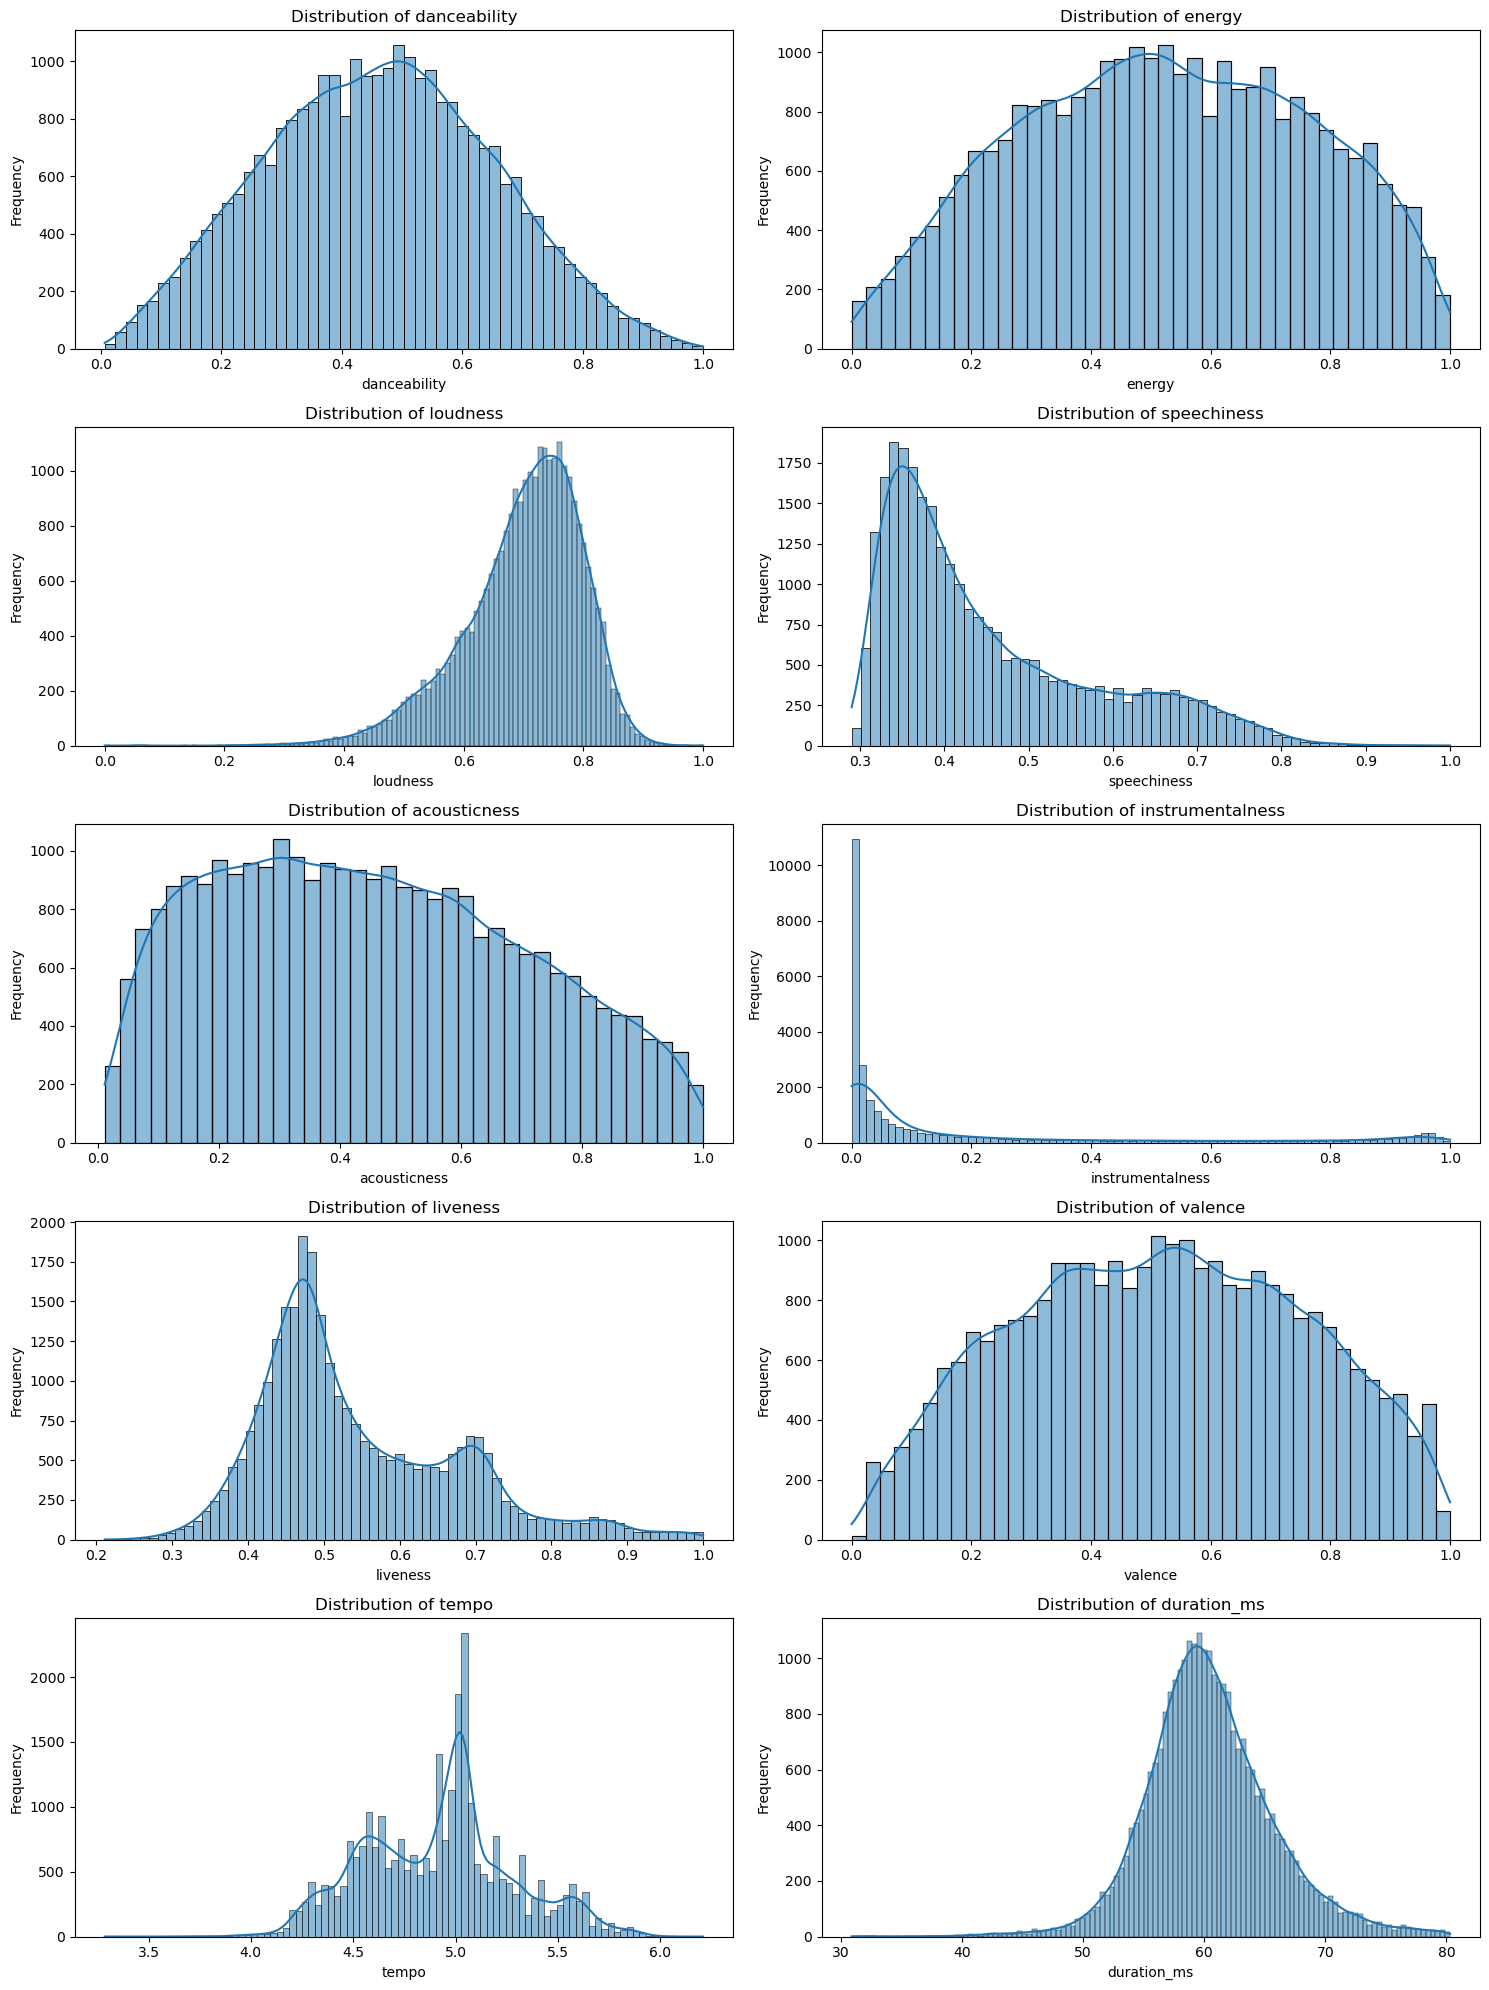

In [7]:
numeric_columns = ["danceability", "energy", "loudness", "speechiness",
    "acousticness", "instrumentalness", "liveness", "valence", "tempo", "duration_ms"
]

plt.figure(figsize=(15, 20))
for i, col in enumerate(numeric_columns, 1):
    plt.subplot(5, 2, i)
    sns.histplot(df_nothing[col], kde=True)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)  
    plt.ylabel("Frequency")  
plt.tight_layout()
plt.show()

#### Distribution of the categorical predictor variables

We then analyzed the categorical variables to look for any anomalies in the data. From the plot below, we can see that all genres are well-represented across the dataset and that there is no class imbalance. These track genres were one-hot encoded in the data pre-processing, meaning that where songs belong to multiple categories (eg. latin pop), this information will be captured.

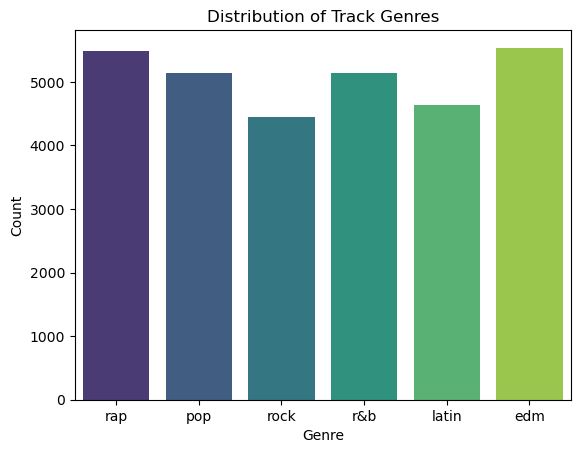

In [8]:
genre_columns = ["rap", "pop", "rock", "r&b", "latin", "edm"]
genre_data = df_nothing[genre_columns]

genre_counts = genre_data.sum().reset_index()
genre_counts.columns = ['Genre', 'Count']  

sns.barplot(data=genre_counts, x='Genre', y='Count', hue='Genre', palette="viridis", legend=False)
plt.title("Distribution of Track Genres")
plt.xlabel("Genre")
plt.ylabel("Count")
plt.show()

#### Distribution of Temporal Variables

Lastly, we investigated the distributions of the temporal variables in our dataset.

When analyzing the plots below, we found that the dataset contains many more observations of recent tracks. This could be beneficial in our case as it may mean current trends are captured more accurately and we are interested in predicting future hits. The distribution of `release month` is fairly similar across all months except for January where there is a significant spike. When combining this observation with the trends in `day of month` which show an overwhelming number of tracks released on the 1st, it might be the case that the default date imputed when the date was missing was January 1st. When carrying out our analysis, we will keep this in mind to ensure that potentially imputed values do not affect the prediction.

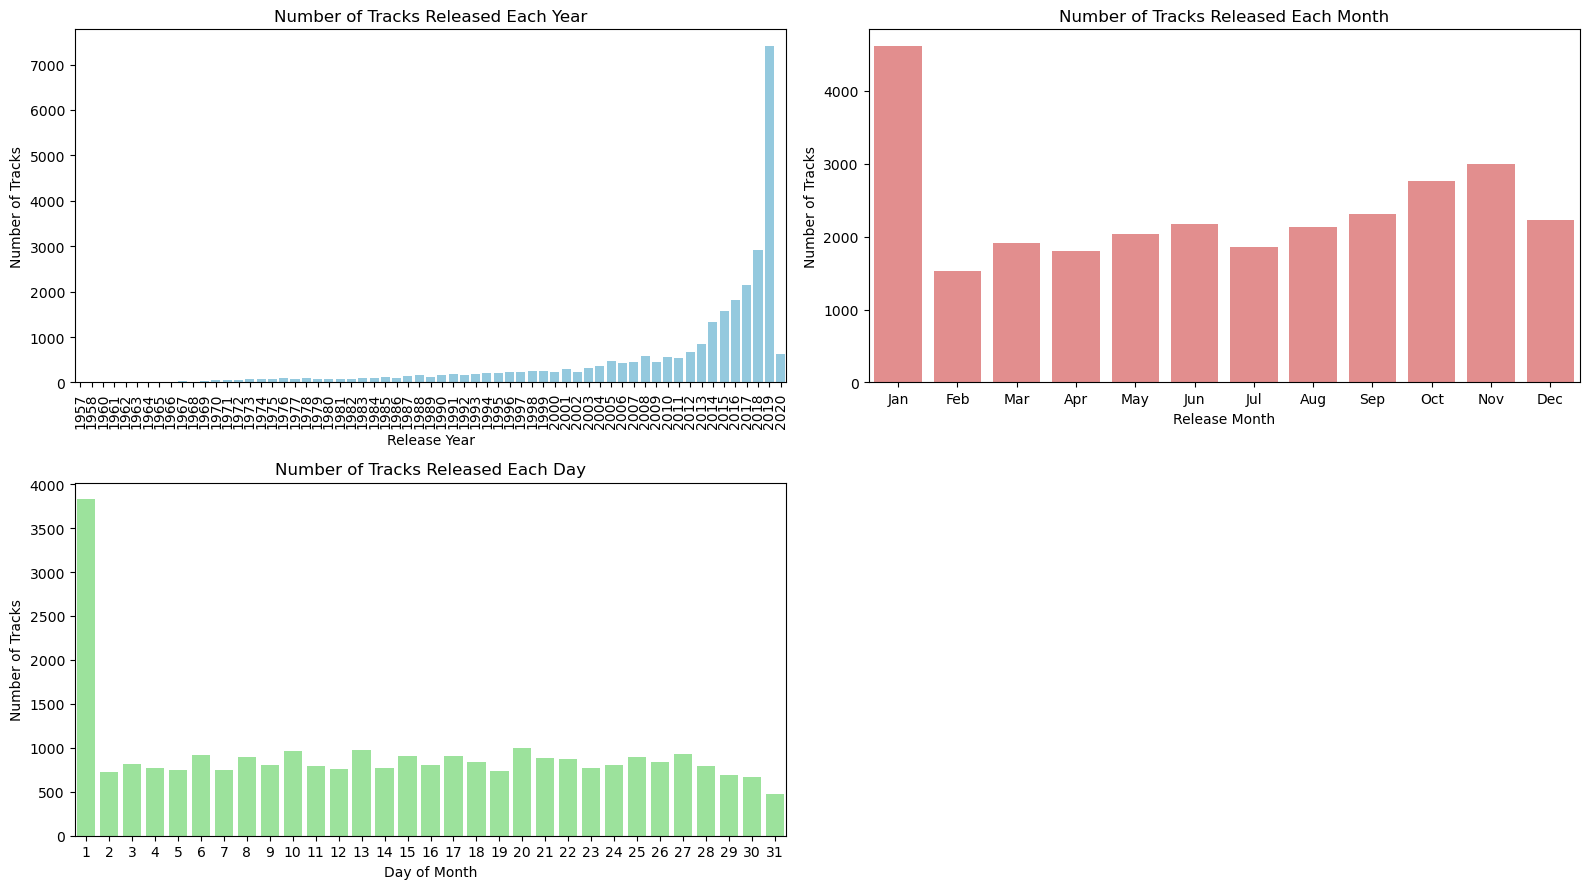

In [9]:
tracks_per_year = df_nothing['release_year'].value_counts().sort_index()
tracks_per_month = df_nothing['release_month'].value_counts().sort_index()
tracks_per_day = df_nothing['release_day'].value_counts().sort_index()

fig, axs = plt.subplots(2, 2, figsize=(16, 9))

# plotting release year distribution
sns.barplot(x=tracks_per_year.index, y=tracks_per_year.values, color="skyblue", ax=axs[0, 0])
axs[0, 0].set_title("Number of Tracks Released Each Year")
axs[0, 0].set_xlabel("Release Year")
axs[0, 0].set_ylabel("Number of Tracks")
axs[0, 0].tick_params(axis='x', rotation=90)

# release month distribution
sns.barplot(x=tracks_per_month.index, y=tracks_per_month.values, color="lightcoral", ax=axs[0, 1])
axs[0, 1].set_title("Number of Tracks Released Each Month")
axs[0, 1].set_xlabel("Release Month")
axs[0, 1].set_ylabel("Number of Tracks")
axs[0, 1].set_xticks(range(12))
axs[0, 1].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], fontsize=10)

# release day distribution
sns.barplot(x=tracks_per_day.index, y=tracks_per_day.values, color="lightgreen", ax=axs[1, 0])
axs[1, 0].set_title("Number of Tracks Released Each Day")
axs[1, 0].set_xlabel("Day of Month")
axs[1, 0].set_ylabel("Number of Tracks")

fig.delaxes(axs[1, 1])  # remove empty fourth plot

plt.tight_layout()
plt.show()

### Relationship between track popularity and predictor variables

As we can see from the plots below, there is no clear relationship between any of the quantitative nor categorical predictors and track popularity.

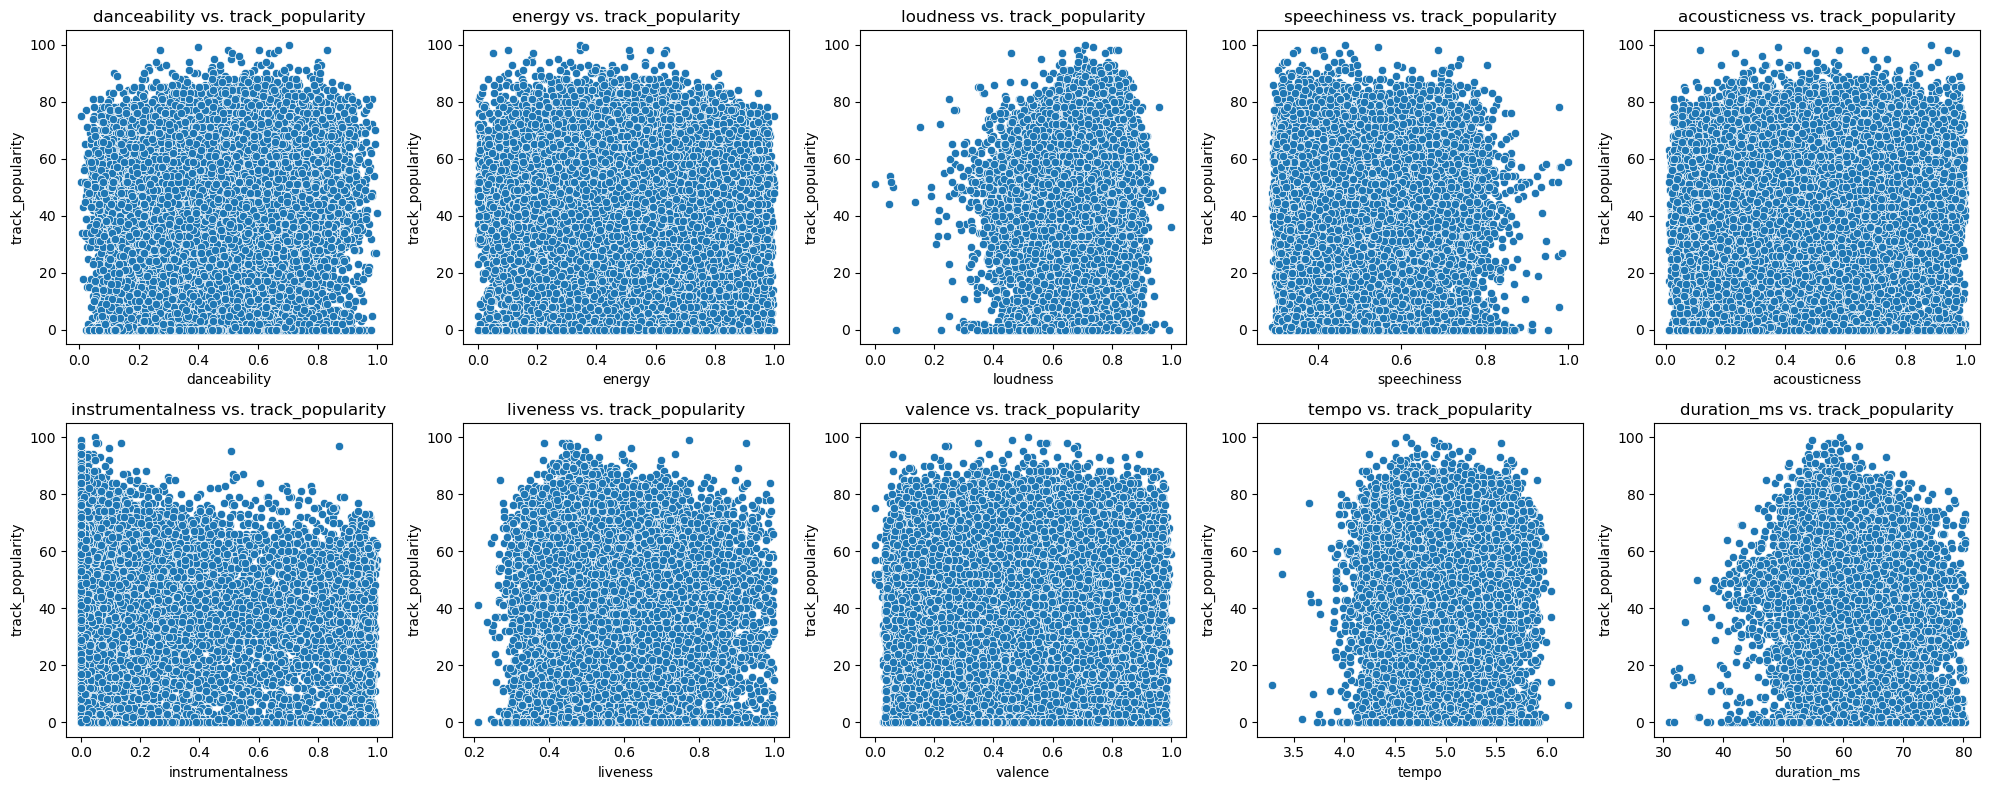

In [10]:
plt.figure(figsize=(20, 8))  
for i, column in enumerate(numeric_columns, 1):
    plt.subplot(2, 5, i)  # 2 rows and 5 columns
    sns.scatterplot(data=df_nothing, x=column, y="track_popularity")
    plt.title(f"{column} vs. track_popularity")
    plt.xlabel(column) 
    plt.ylabel("track_popularity") 

plt.tight_layout()
plt.show()

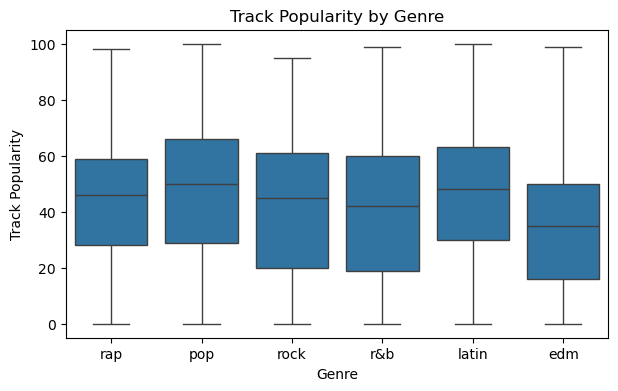

In [11]:
# make sure data is tidy; melt genre columns into a single column, binary indicator into one column
data_melted = df_nothing.melt(id_vars=["track_popularity"], value_vars=genre_columns, 
                        var_name="Genre", value_name="Is_Present")

data_genre = data_melted[data_melted["Is_Present"] == 1]

plt.figure(figsize=(7, 4))
sns.boxplot(data=data_genre, x="Genre", y="track_popularity")
plt.title("Track Popularity by Genre")
plt.xlabel("Genre")
plt.ylabel("Track Popularity")
plt.show()

Similarly, when analyzing the relationship between the temporal variables and the target variable we find no clear relationship. This was slightly
surprising as we might expect specific days such as Christmas or ‘summer songs’ months to influence a song’s popularity. 

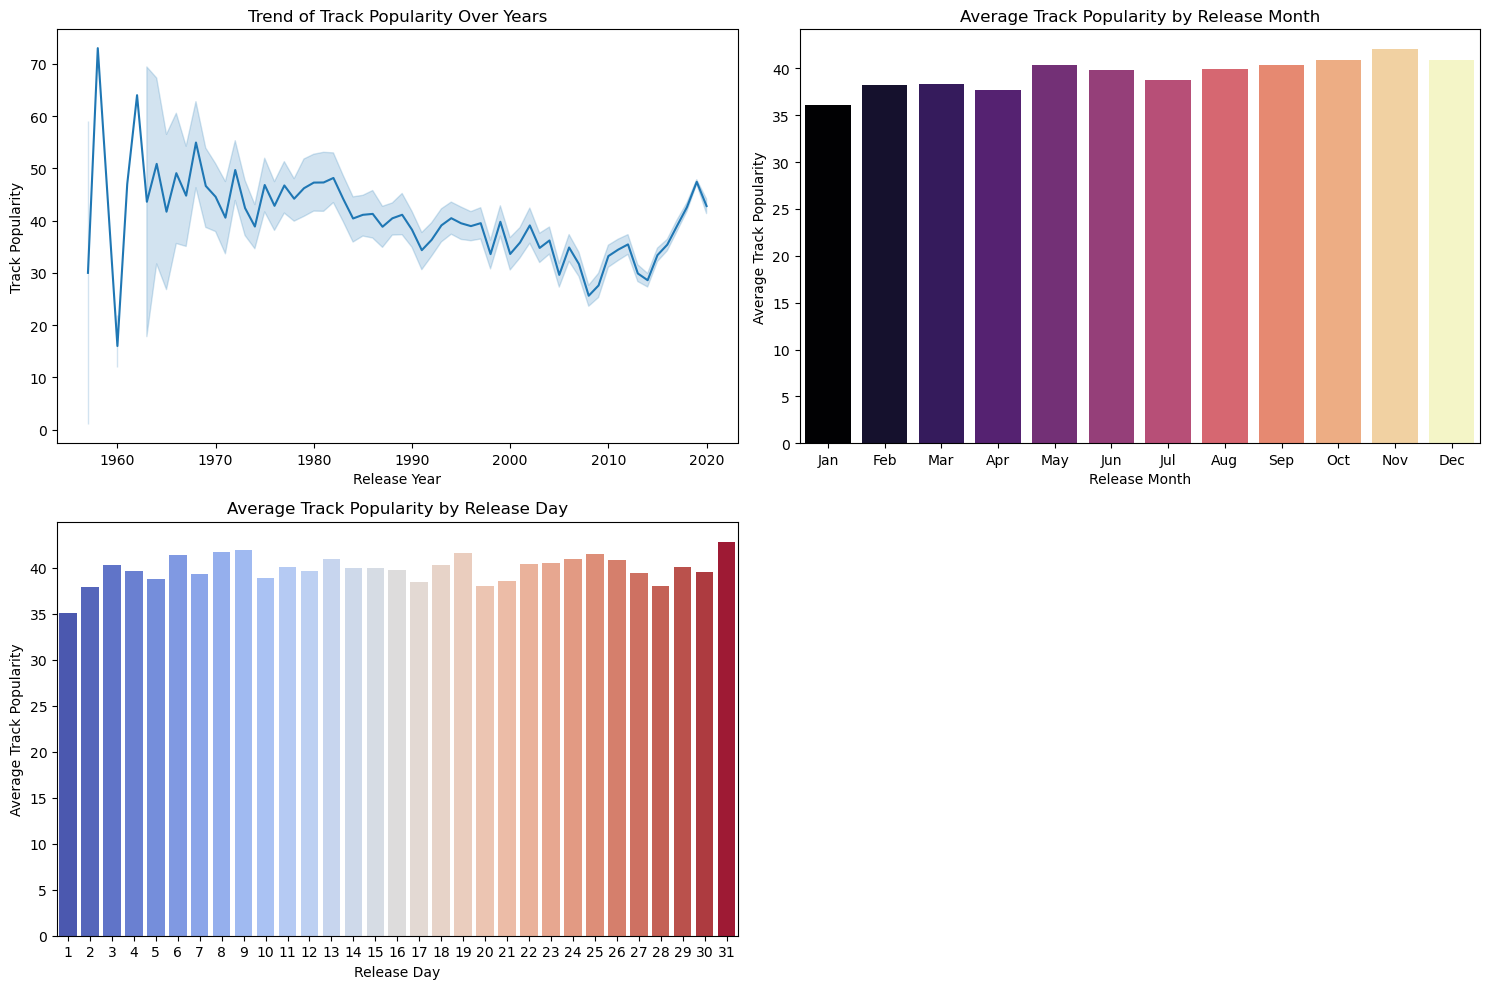

In [12]:
popularity_by_month = df_nothing.groupby('release_month')['track_popularity'].mean().reset_index()
popularity_by_day = df_nothing.groupby('release_day')['track_popularity'].mean().reset_index()

fig, axs = plt.subplots(2, 2, figsize=(15, 10))  # Adjust figsize for better readability

# trend of track popularity over years
sns.lineplot(data=df_nothing, x="release_year", y="track_popularity", errorbar=('ci', 95), ax=axs[0, 0])
axs[0, 0].set_title("Trend of Track Popularity Over Years")
axs[0, 0].set_xlabel("Release Year")
axs[0, 0].set_ylabel("Track Popularity")

# track popularity by release month
sns.barplot(data=popularity_by_month, x="release_month", y="track_popularity", hue="release_month", palette="magma", ax=axs[0, 1], dodge=False, legend=False)
axs[0, 1].set_title("Average Track Popularity by Release Month")
axs[0, 1].set_xlabel("Release Month")
axs[0, 1].set_ylabel("Average Track Popularity")
axs[0, 1].set_xticks(range(12))
axs[0, 1].set_xticklabels(["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])

# track popularity by release day
sns.barplot(data=popularity_by_day, x="release_day", y="track_popularity", hue="release_day", palette="coolwarm", ax=axs[1, 0], dodge=False, legend=False)
axs[1, 0].set_title("Average Track Popularity by Release Day")
axs[1, 0].set_xlabel("Release Day")
axs[1, 0].set_ylabel("Average Track Popularity")
axs[1, 0].set_xticks(range(0, 31))
axs[1, 0].set_xticklabels(range(1, 32))

fig.delaxes(axs[1, 1]) # remove empty subplot 

plt.tight_layout()
plt.show()

### Feature correlation

We investigate potential correlation between the numerical predictor variables. As we can see, loudness and energy appear to be fairly correlated, although there are no extremely strong correlations to take note of.

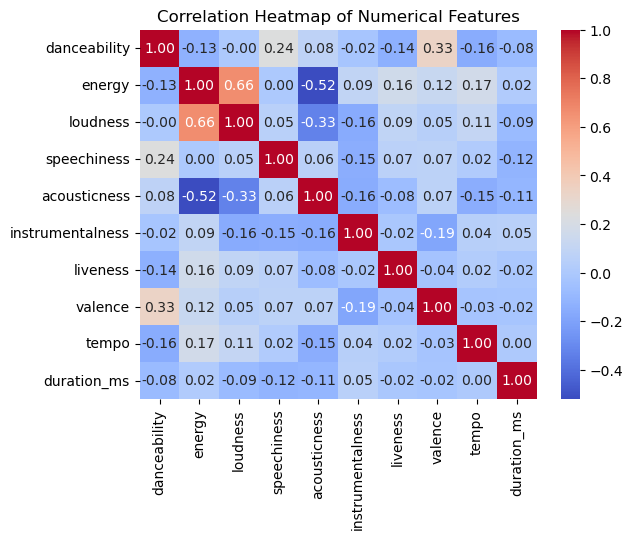

In [13]:
sns.heatmap(df_nothing[numeric_columns].corr(), annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Heatmap of Numerical Features")
plt.show()

### Outliers

As we noted from analysis in our prior milestone, this dataset contains a large number of outliers, leverage and influential points. After our initial analysis, we removed outliers that appeared to be particularly egregious and potentially mistakes. None of the remaining outliers appeared to be isolated, and they were distributed across all music genres.

From our knowledge about music more generally, it is not surprising that there are outliers. Music inherently has a lot of variation, particularly as artists tend to experiment occasionally with unusual styles or characteristics. We therefore decide to keep these remaining outliers, as they represent distinct styles of music. For our case of prediction, keeping outliers might make the model more adaptable to different music styles. The distribution of the variables with the remaining outliers can be seen below.

In [14]:
numeric_df = df_nothing.select_dtypes(include=[np.number])
outlier_counts = (np.abs(zscore(numeric_df)) > 3).sum().astype(int)
print("Outliers per predictor:")
print(outlier_counts)

Outliers per predictor:
track_popularity          0
danceability              0
energy                    0
key                       0
loudness                238
mode                      0
speechiness              93
acousticness              0
instrumentalness          0
liveness                260
valence                   0
tempo                    17
duration_ms             368
edm                       0
r&b                       0
rap                       0
latin                     0
rock                      0
pop                       0
artist_track_encoded      1
release_year            748
release_month             0
release_day               0
Cluster                   0
dtype: int64


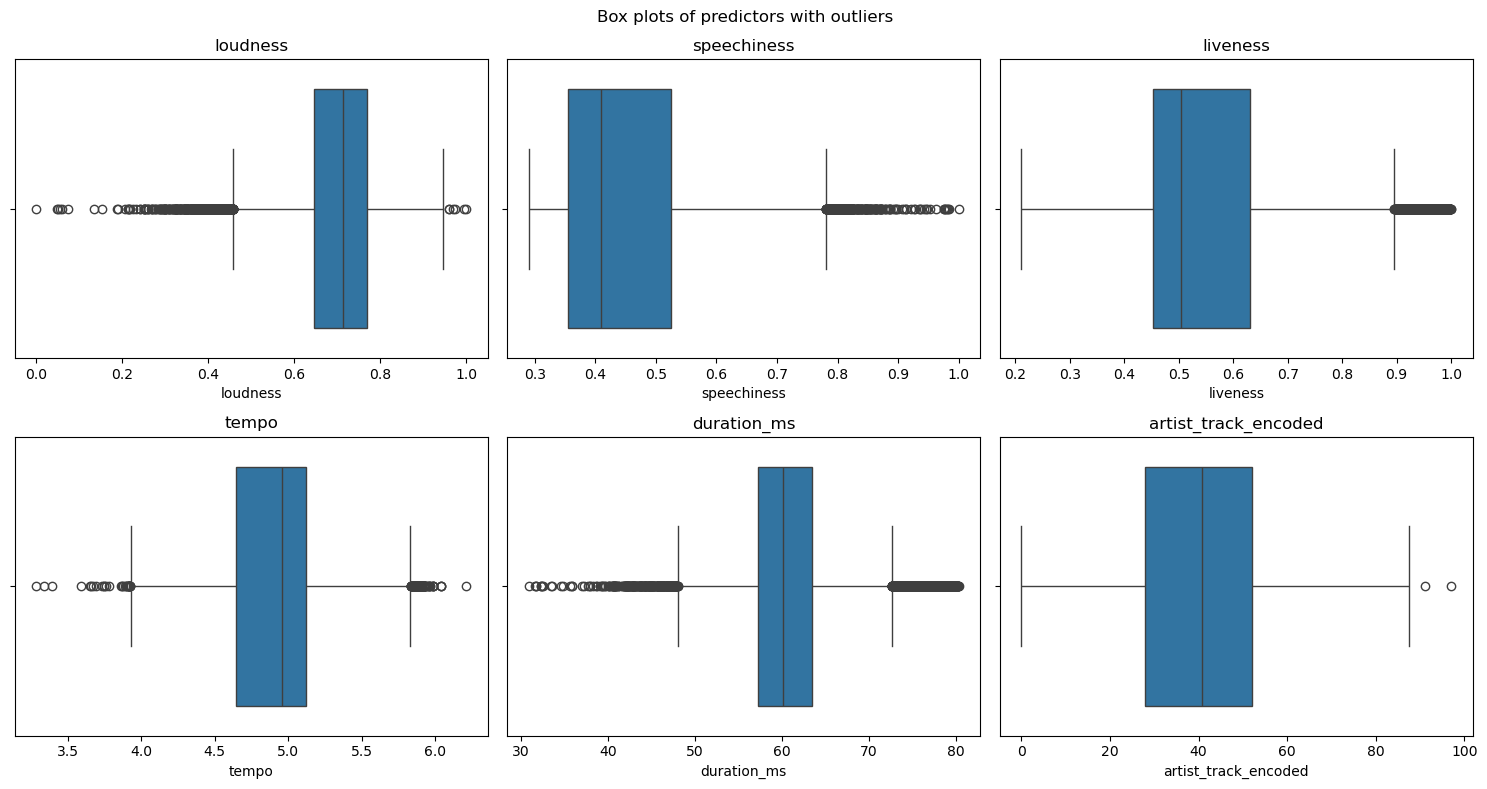

In [15]:
outlier_predictors = ["loudness", "speechiness", "liveness", "tempo", "duration_ms", "artist_track_encoded"]

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
fig.suptitle("Box plots of predictors with outliers")

for i, predictor in enumerate(outlier_predictors):
    row, col = divmod(i, 3)
    sns.boxplot(x=df_nothing[predictor], ax=axes[row, col])
    axes[row, col].set_title(f"{predictor}")

plt.tight_layout()
plt.show()

## 3. Baseline Models
<a id="baseline"></a>

As discussed above, we considered three different ways to deal with the skew in the target variable where there are a high number of points with zero popularity. We will test our baseline models against these 3 preprocessing methods to evaluate which is the best.

We will consider three different baseline models before choosing the best:
- Linear regression (predicting the popularity value)
- Logistic regression (classification into different 'popularity levels')
- Decision tree (classification into different 'popularity levels')

There are two approaches we could take for determining the popularity of a song. As `track_popularity` is a numerical value, we could look at the raw numerical value that is predicted. Alternatively, we could divide different popularities into bins indicating the level of popularity (where songs at level 0 are least popular, and those at level 2 are the most popular). Linear regression addresses this first approach, where as logistic regression and decision trees will address the latter. 

In [16]:
# Split each of the 3 datasets into train and test sets
X_nothing = df_nothing.drop(columns=["track_popularity"])
y_nothing = df_nothing["track_popularity"]

X_train_nothing, X_test_nothing, y_train_nothing, y_test_nothing = train_test_split(X_nothing, y_nothing, test_size=0.2, random_state=42)

X_0mean = df_0mean.drop(columns=["track_popularity"])
y_0mean = df_0mean["track_popularity"]

X_train_0mean, X_test_0mean, y_train_0mean, y_test_0mean = train_test_split(X_0mean, y_0mean, test_size=0.2, random_state=42)

X_no0 = df_no0.drop(columns=["track_popularity"])
y_no0 = df_no0["track_popularity"]

X_train_no0, X_test_no0, y_train_no0, y_test_no0 = train_test_split(X_no0, y_no0, test_size=0.2, random_state=42)

In [17]:
# define helper function to compare baseline models efficiently

def get_metrics(model, name: str, data: tuple) -> dict:
    x_train, x_test, y_train, y_test = data
    d = {}
    y_hat_train = model.predict(x_train)
    y_hat_test = model.predict(x_test)
    d['name'] = name
    d['train_mse'] = mean_squared_error(y_train, y_hat_train)
    d['test_mse'] = mean_squared_error(y_test, y_hat_test)
    d['r2_train'] = r2_score(y_train, y_hat_train)
    d['r2_test'] = r2_score(y_test, y_hat_test)
    return d

### Regression Baseline Model
<a id="sub1"></a>

As discussed above, we will utilize linear regression to predict a raw value for `track_popularity`, considering each of the three options for dealing with the large number of zero popularity tracks. We fit the model using the `LinearRegression()` function.

**Linear regression - no transformation to zero popularity tracks**

In [18]:
lin_reg_nothing = LinearRegression().fit(X_train_nothing, y_train_nothing)
data = (X_train_nothing, X_test_nothing, y_train_nothing, y_test_nothing)
results = [get_metrics(lin_reg_nothing, 'Linear Regression - no transformation', data)]

**Linear regression - impute with mean of artist's non-zero popularity songs**

In [19]:
lin_reg_0mean = LinearRegression().fit(X_train_0mean, y_train_0mean)
data = (X_train_0mean, X_test_0mean, y_train_0mean, y_test_0mean)
results.append(get_metrics(lin_reg_0mean, 'Linear Regression - imputed popularity', data))

**Linear regression - remove songs with zero popularity**

In [20]:
lin_reg_no0 = LinearRegression().fit(X_train_no0, y_train_no0)
data = (X_train_no0, X_test_no0, y_train_no0, y_test_no0)
results.append(get_metrics(lin_reg_no0, 'Linear Regression - zero popularity removed', data))

**Linear regression baseline model results**

In [21]:
pd.DataFrame(results)

,name,train_mse,test_mse,r2_train,r2_test
0,Linear Regression - no transformation,245.039662,246.167447,0.562991,0.564431
1,Linear Regression - imputed popularity,198.073948,193.928842,0.595469,0.601986
2,Linear Regression - zero popularity removed,216.015713,216.208288,0.514456,0.517065


As we can see from the results, Model 1 (imputed popularity) has both the lowest train and test MSE, indicating that it is better at predicting `track_popularity` than the other two models. Furthermore, the similar train and testing MSEs suggest that the model is not overfit. The performances of Models 0 and 2 are a lot worse when looking at MSE, although that wit no transformation is notably poorer. It seems that imputing the popularity using artist mean may have introduced additional information to improve the model predictions.

Model 1 had the highest R-squared score across both test and training sets. The R-squared test score for Model 0 indicates that the model captures 60.2% of the variance in the data. While the R-squared scoreS for Models 0 and 1 were both slightly lower, with Model 2 only explaining around 51.7% of the variance in the data. This may be due to the nature of removing the zero values entirely which could have introduced inaccuracies and bias.

For linear regression, utilizing the imputed popularity appears to improve predictions.

### Classification Baseline Models (using 3 levels)
<a id="sub2"></a>

For the classification methods, we will break up `track_popularity` into 3 levels of popularity where 0 represents the least popular songs and 2 are the most popular songs.

##### Encode `track_popularity` into levels

In [22]:
# create a levels and labels for the popularity
num_categories = 3

bins = [i * (100 / num_categories) for i in range(num_categories + 1)]
labels = list(range(0, num_categories))

In [23]:
# create a new column for the popularity category level
df_nothing['popularity_category'] = pd.cut(
    df_nothing['track_popularity'], bins=bins, labels=labels, include_lowest=True)

df_nothing = df_nothing.drop(columns=["track_popularity"])

df_0mean['popularity_category'] = pd.cut(
    df_0mean['track_popularity'], bins=bins, labels=labels, include_lowest=True)

df_0mean = df_0mean.drop(columns=["track_popularity"])

df_no0['popularity_category'] = pd.cut(
    df_no0['track_popularity'], bins=bins, labels=labels, include_lowest=True)

df_no0 = df_no0.drop(columns=["track_popularity"])

**Split into train and test sets with the new levels**

In [24]:
X_nothing = df_nothing.drop(columns=["popularity_category"])
y_nothing = df_nothing["popularity_category"]

X_train_nothing, X_test_nothing, y_train_nothing, y_test_nothing = train_test_split(X_nothing, y_nothing, test_size=0.2, random_state=42)

X_0mean = df_0mean.drop(columns=["popularity_category"])
y_0mean = df_0mean["popularity_category"]

X_train_0mean, X_test_0mean, y_train_0mean, y_test_0mean = train_test_split(X_0mean, y_0mean, test_size=0.2, random_state=42)

X_no0 = df_no0.drop(columns=["popularity_category"])
y_no0 = df_no0["popularity_category"]

X_train_no0, X_test_no0, y_train_no0, y_test_no0 = train_test_split(X_no0, y_no0, test_size=0.2, random_state=42)

We can visualize the spread of the data now that it has been split into different levels of popularity - we call these the popularity categories where category 0 are the least popular songs and category 2 are the most popular songs.

From the plots below, we can see that category 2 has the lowest number of songs across the board. This supports our understanding of the nature of music data: not many songs become hits. We can see from these distributions that the number of values in the lowest popularity category decreased when transforming zero popularity values. When considering this classification approach, it seems that the zero values for popularity may not be as impactful as when using linear regression - zero values are no longer as much of a problem.

However, we note that there is now imbalance with cateogry 2 having far fewer values than the other categories which we will need to account for.

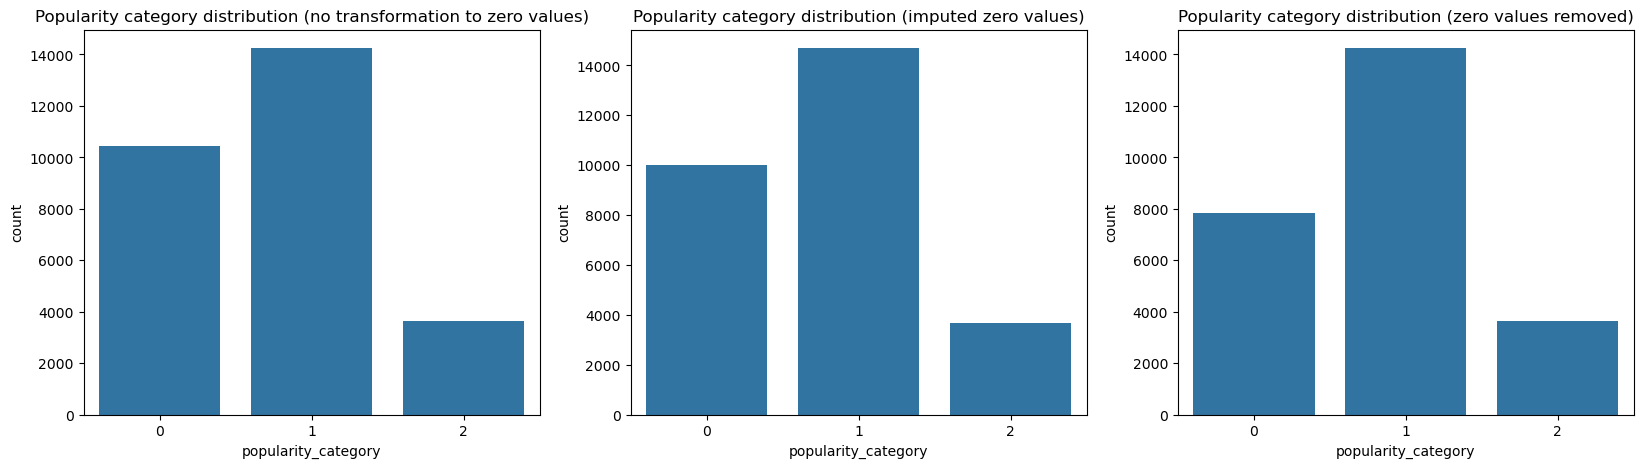

In [25]:
# plot distribution of popularity categories

fig, ax = plt.subplots(1, 3, figsize=(20, 5))

sns.countplot(x='popularity_category', data=df_nothing, ax=ax[0])
ax[0].set_title('Popularity category distribution (no transformation to zero values)')

sns.countplot(x='popularity_category', data=df_0mean, ax=ax[1])
ax[1].set_title('Popularity category distribution (imputed zero values)')

sns.countplot(x='popularity_category', data=df_no0, ax=ax[2])
ax[2].set_title('Popularity category distribution (zero values removed)')

plt.show()

### Decision Tree
<a id="subclass1"></a>

We will consider various depths for each of the decision trees, evaluating each of the possible baseline models using cross-validation. We fit each model as a `DecisionTreeClassifier()` using cross validation calculated using `cross_val_score`. We evaluate these validation scores using the F1 score.

In [26]:
results = []

depths = np.arange(1, 21) 

def evaluate_with_cv(X_train, y_train,X_val,y_val, transformation_label):
    train_f1 = []
    test_f1 = []
    for depth in depths:
        clf = DecisionTreeClassifier(max_depth=depth)
        scores = cross_val_score(
            clf, X_train, y_train, cv=5, scoring='f1_macro')  
        train_f1.append(np.mean(scores))
        test_f1.append(f1_score(y_val, clf.fit(X_train, y_train).predict(X_val), average='macro'))
    best_result = max(test_f1)
    best_depth = depths[test_f1.index(best_result)]

    # Add results to the global results list
    results.append(
        ["Decision Tree", transformation_label, best_result, best_depth])

    return train_f1, test_f1

**Decision tree - no transformation to zero popularity tracks**

In [27]:
train_f1_nothing, test_f1_nothing = evaluate_with_cv(X_train_nothing, y_train_nothing,X_test_nothing,y_test_nothing,"No transformation")

**Decision tree - impute with mean of artist's non-zero popularity songs**

In [28]:
train_f1_0mean, test_f1_0mean = evaluate_with_cv(
    X_train_0mean, y_train_0mean,X_test_0mean,y_test_0mean,"Imputed values")

**Decision Tree - remove songs with zero popularity**

In [29]:
train_f1_no0, test_f1_no0 = evaluate_with_cv(
    X_train_no0, y_train_no0,X_test_no0,y_test_no0, "Zeros removed")

**Decision tree baseline model results**

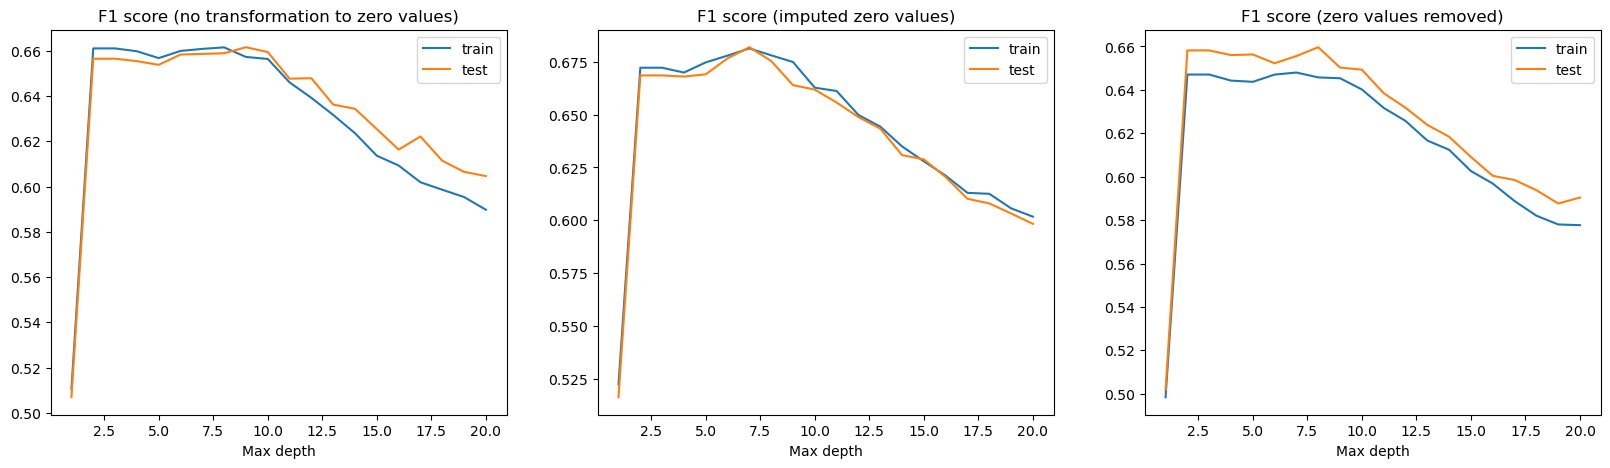

In [30]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

ax[0].plot(depths, train_f1_nothing, label='train')
ax[0].plot(depths, test_f1_nothing, label='test')
ax[0].set_title('F1 score (no transformation to zero values)')
ax[0].set_xlabel('Max depth')
ax[0].legend()

ax[1].plot(depths, train_f1_0mean, label='train')
ax[1].plot(depths, test_f1_0mean, label='test')
ax[1].set_title('F1 score (imputed zero values)')
ax[1].set_xlabel('Max depth')
ax[1].legend()

ax[2].plot(depths, train_f1_no0, label='train')
ax[2].plot(depths, test_f1_no0, label='test')
ax[2].set_title('F1 score (zero values removed)')
ax[2].set_xlabel('Max depth')
ax[2].legend()

plt.show()

In [31]:
col = ["Model", "Dataset", "F1 score", "Best Depth"]

pd.DataFrame(results, columns=col)

,Model,Dataset,F1 score,Best Depth
0,Decision Tree,No transformation,0.661601,9
1,Decision Tree,Imputed values,0.681906,7
2,Decision Tree,Zeros removed,0.659634,8


From the results above, we can see that decision trees performed similarly across all three ways of dealing with the zero values. Furthermore, the best depth for each, assessed using the F1 score metric, all preferred trees of similar depths. As we can see from the plots above, when increasing the depth past around 10, the trees became overfit across all three trees as the test F1 score would begin to decrease.

The decision tree with the imputed values performed the best, although this performance was only slightly better than the other two. Unlike with the linear regression model, there was not a large different between the performance outcome metric across the three models. It is notable that the decision tree with imputed values performed best, similarly to the outcome with the linear regression models.

### Logistic Regression
<a id="subclass2"></a>

We fit the logistic regression models again on each og the datasets using the `LogisticRegression()` function. 

In [32]:
def evaluate_log_reg_with_cv(X_train, y_train,X_val,y_val, transformation_label):
    log_reg = LogisticRegression(solver='saga', max_iter=2000)
    scores = cross_val_score(
        log_reg, X_train, y_train, cv=5, scoring='f1_macro') 

    # calculate train accuracy 
    mean_cv_f1 = np.mean(scores)
    test_f1 = f1_score(y_val, log_reg.fit(X_train, y_train).predict(X_val), average='macro')
    # add results to the global results list
    results.append(
        ["Logistic Regression", transformation_label, test_f1, None])

    return mean_cv_f1

**Logistic regression - no transformation to zero popularity tracks**

In [33]:
f1_nothing = evaluate_log_reg_with_cv(
    X_train_nothing, y_train_nothing,X_test_nothing,y_test_nothing, "No transformation")
print(
    f"Logistic Regression (No transformation) CV F1 core: {f1_nothing:.4f}")

Logistic Regression (No transformation) CV F1 core: 0.6456


**Logistic regression - impute with mean of artist's non-zero popularity songs**

In [34]:
f1_0mean = evaluate_log_reg_with_cv(
    X_train_0mean, y_train_0mean,X_test_0mean,y_test_0mean, "Imputed values")
print(
    f"Logistic Regression (Imputed values) CV F1 score: {f1_0mean:.4f}")

Logistic Regression (Imputed values) CV F1 score: 0.6525


**Logistic regression - remove songs with zero popularity**

In [35]:
f1_no0 = evaluate_log_reg_with_cv(
    X_train_no0, y_train_no0,X_test_no0,y_test_no0, "Zeros removed")
print(f"Logistic Regression (Zeros removed) CV F1 score: {f1_no0:.4f}")

Logistic Regression (Zeros removed) CV F1 score: 0.6224


**Logistic regression baseline model results**

In [36]:
pd.DataFrame(results, columns=col)

,Model,Dataset,F1 score,Best Depth
0,Decision Tree,No transformation,0.661601,9.0
1,Decision Tree,Imputed values,0.681906,7.0
2,Decision Tree,Zeros removed,0.659634,8.0
3,Logistic Regression,No transformation,0.639087,NaN
4,Logistic Regression,Imputed values,0.646224,NaN
5,Logistic Regression,Zeros removed,0.632542,NaN


From the results above, we can see that for the logistic regression models, the one which utilised the imputed data performed best. This coincides with what we have seen for the linear regression and decision tree models.

**Selecting our baseline model**

Across the linear regression, decision tree and logistic regression models, the dataset with imputed values for zeros performed the best. Moving forward, we therefore decide to **use the dataset with imputed values**.

We decide on using a **classification** approach as opposed to regression as it may be more interpretable in this context. For example, distinguishing between 3 levels of popularity is more understandable than a sliding scale of popularity values such as in the case of reporting these predictions and explaining the system to industry personnel. Furthermore, the classification approach is more robust to the number of zero popularity values - when grouped together in the lowest bin, the data is not as imbalanced anymore. 

We note that the accuracies for the logistic regression models are lower than those for the decision trees across the board. This could be due to the complexity of the dataset or perhaps the imbalance in the dataset meaning that decision trees may simply be more suited to our dataset, and that a more complex decision boundary captures the data better. We therefore decide to use the Decision Tree as our baseline model, and will refine it further in our next milestone.

Therefore, we select the Decision Tree and the dataset with no transformation to the zero values for our baseline model.

## Final model pipeline
<a id="pipeline"></a>

Based on our analysis, we will move forward with the Decision Tree classifier as our baseline model using the dataset with imputed popularity values. We will explore different options to try to further improve our classifier such as Random Forests and Boosting, as well as fine tuning the hyperparameters. 

As discussed, we will use the dataset with imputed popularity values. Given the way we divided the popularity into levels, the zero values are no longer as problematic as before, however we do now have an imbalance as there are relatively few songs that are hits. We will therefore consider data resampling techniques such as SMOTE in our model pipeline.

#### Feature Engineering

We start by defining a FeatureEngineering class for our pipeline. Efficiently transforming our dataset will allow us to try different transformations to understand which transformations might work best.

In [37]:
class FeatureEngineeringTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        # no fitting required but the method is necessary
        return self

    def transform(self, X):
        X = X.copy()

       # some feature engineering
        X['energy_danceability'] = X['energy'] * X['danceability']
        X['tempo_energy_interaction'] = X['tempo'] * X['energy']
        X['dance_valence'] = X['danceability'] * X['valence']

        X['track_age'] = 2024 - X['release_year']
        
        # flexibility to add more features in the future
        X['release_season'] = X['release_month'].apply(self._categorize_season)
        X['loudness_log'] = np.log1p(X['loudness'].clip(lower=1))
        X['instrumentalness_log'] = np.log1p(X['instrumentalness'])

        X = pd.get_dummies(X, columns=['release_season'], drop_first=True)

        return X
    
    @staticmethod
    def _categorize_season(month):
        if month in [12, 1, 2]:
            return 'Winter'
        elif month in [3, 4, 5]:
            return 'Spring'
        elif month in [6, 7, 8]:
            return 'Summer'
        else:
            return 'Fall'

#### Pipeline definition

As the pre-processing was done in an other notebook and saved into a new CSV files, we do not need to include a pre-processing step in our pipeline.

**Re-sampling**

As discussed above, category 2 (the most popular songs) has disproportionately few samples compared to the other categories. One possible way to handle this is to use re-sampling. We can directly incorporate imputation in our pipeline.

Here we use SMOTE for our baseline, however, we may consider other options as we fine-tune our model to see which technique works best. We implement this using the `SMOTE()` function. We fit the pipeline using the `Pipeline()` function.

In [38]:
resampler = SMOTE(random_state=42)
model= DecisionTreeClassifier(class_weight='balanced', random_state=42) 

pipeline_decision_tree = Pipeline([
    ('feature_engineering', FeatureEngineeringTransformer()),
    ('resampler', resampler),
    ('model', model)
])

pipeline_decision_tree

Pipeline(steps=[('feature_engineering', FeatureEngineeringTransformer()),
                ('resampler', SMOTE(random_state=42)),
                ('model',
                 DecisionTreeClassifier(class_weight='balanced',
                                        random_state=42))])

We will employ this pipeline as we fine-tune our parameters, as well as test out techniques such as random forest and gradient boosting. 

#### Example of the pipeline

In [39]:
pipeline_decision_tree.fit(X_train_0mean, y_train_0mean)

accuracy_score_train = pipeline_decision_tree.score(X_train_0mean, y_train_0mean)
accuracy_score_test = pipeline_decision_tree.score(X_test_0mean, y_test_0mean)

print(f"Train accuracy: {accuracy_score_train:.2f}")
print(f"Test accuracy: {accuracy_score_test:.2f}")

Train accuracy: 1.00
Test accuracy: 0.63


## Classification model
<a id="classification"></a>

In our baseline model stage, we determined that the best dataset to use in this case is that where the zeros popularity values are imputed. Since we decided on a decision tree as our baseline model, we are now working with popularity categories as our outcome variable - this change means that the skew from the large number of zero-popularity tracks is now no longer an issue. However, we now have a new issue in that the popularity categories are imbalanced due to the nature of music data - not that many songs become hits and therefore fewer songs fall into the most popular category.

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X_0mean, y_0mean, test_size=0.2, random_state=42)

We will also perform cross-validation during the model training for fine-tuning hyperparmeters. In this case, we decide to use Stratified K-Fold cross-validation. We decide to use this here because, as discussed above, there is an imbalanced distribution across the different categories of the outcome variable track popularity. This way, we ensure that the dataset's distribution is reflected across all folds which guarantees representation of the minority classes in each fold. 

In [41]:
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

In [42]:
results = []

#### Evaluating the models - using the F1 score

Given the imbalance in our dataset, we choose to compare the models using the F1 score to avoid misrepresenting model performance on the minority class. Furthermore, in the context of this problem, we also care about false positives and false negatives as there are costs involved with incorrectly identifying songs, or not being able to capitalize on potential hits. That said, we note that we may be more concerned about false positives than false negatives - false negatives would be songs that are not initially identified as being popular, but may turn out to be hits. In these cases, labels can begin to capitalize on a song's popularity after the fact (although this would not be ideal). However, for false negatives, a lot of resources could go into a song that is predicted to become popular, when in fact it does not resonate with audiences as anticipated.

#### SMOTE

Given the imbalance in our dataset, we include SMOTE as part of our pipeline across all models. The most popular songs (category 2) are underrepresented in the dataset, however they are the most important as identifying hit songs is the most important component of our predictions. The most popular songs are the ones that both consumers and the industry will want to prioritize.

### Fine-tuning the Decision Tree
<a id="finetuned"></a>

We begin finetuning the Decision Tree baseline model to improve its accuracy once again using `DecisionTreeClassifier()`. We firstly use `GridSearchCV()` to find the best hyperparameters for the models.

In [43]:
start_time = time.time()

param_grid = {
    'model__max_depth': [None, 5, 7, 10,],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
    'model__max_features': [None, 'sqrt', 'log2'],
    'model__criterion': ['gini', 'entropy']
}

model = DecisionTreeClassifier(class_weight='balanced', random_state=42)

grid_search = GridSearchCV(
    estimator=pipeline_decision_tree,
    param_grid=param_grid,
    scoring='f1_macro',  
    cv=cv,                
    n_jobs=-1,           
    verbose=1
)
# fit the model
grid_search.fit(X_train, y_train)

end_time = time.time()
training_duration = end_time - start_time
print(f"Total training time: {training_duration:.2f} seconds")

# extract best hyperparameters and best score from gridsearch
print("Optimal hyperparameters found:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

best_pipeline = grid_search.best_estimator_
# predict using best hyperparameters
y_pred = best_pipeline.predict(X_test)

print("Classification Report using optimal hyperparmeters:")
print(classification_report(y_test, y_pred))

accuracy_decision_tree = accuracy_score(y_test, y_pred)
print("Test score (using optimal hyperparameters):", accuracy_decision_tree)
f1_decision_tree = f1_score(y_test, y_pred, average='macro')
print("F1 score:", f1_decision_tree)

Fitting 3 folds for each of 216 candidates, totalling 648 fits
Total training time: 32.20 seconds
Optimal hyperparameters found: {'model__criterion': 'gini', 'model__max_depth': 5, 'model__max_features': None, 'model__min_samples_leaf': 4, 'model__min_samples_split': 2}
Best cross-validation score: 0.6776298483084303
Classification Report using optimal hyperparmeters:
              precision    recall  f1-score   support

           0       0.80      0.77      0.78      2020
           1       0.74      0.81      0.77      2898
           2       0.62      0.46      0.53       753

    accuracy                           0.75      5671
   macro avg       0.72      0.68      0.69      5671
weighted avg       0.74      0.75      0.74      5671

Test score (using optimal hyperparameters): 0.7476635514018691
F1 score: 0.6947898934690945


Using the optimal parameters found from GridSearchCV, the Decision Tree has an overall test accuracy of 74.8% and a F1 score of 0.69. 

We can plot the confusion matrix for the test set predictions from the Decision Tree that used the optimal hyperparameters found in the GridSearchCV above. As we can see from the plot below, within each of the categories, the model predicted the correct label more times than not except for category 2. In category 0, 1606/2126 = 75.5% of points were classified accurately. In category 1, this percentage was 2187/2785 = 78.5%, and in category 2 this percentage was 355/760 = 46.7%. The F1 scores of 0.77 for category 0, 0.75 for category 1 and 0.52 for category 2 similarly demonstrate a poorer performance on category 2.

The model was notably worse at predicting category 2 songs compared to the other categories - this is could be due to imbalance in the data since not as many songs become hits. Furthermore, there might be a large variety in which songs become popular based on genre and other musical features which could make hits harder to predict. This could be problematic as identifying hit songs is what is ultimately the goal in this model's implementation.

That said, we note that the model struggles more with classifying songs that are in the next category - for example, looking at the true labels for songs in cateogry 0, when the model misclassifies a song, it is more likely to classify it into category 1 than category 2. If the model is to make a mistake, it is likely to predict in the next class as opposed to two classes away. The majority of misclassified points in category 2 were predicted as category 1. Therefore, it seems that there are overarching trends in the data, but that the current model does not capture the nuance.

We next explore Random Forests, which could help when dealing with the complexity and capturing the nuance in the data.

Text(0.5, 1.0, 'Confusion Matrix for Decision Tree')

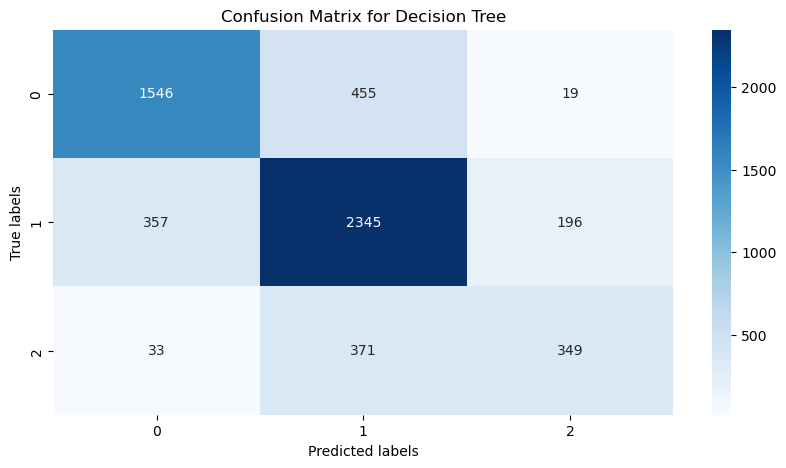

In [44]:
# confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Decision Tree')

In [45]:
results.append(["Decision Tree", accuracy_decision_tree, f1_decision_tree,training_duration])

### Random Forest
<a id="forest"></a>

We next try to improve on our fine-tuned decision tree by employing a Random Forest. Aggregating the predictions of multiple decision trees to produce a final prediction may help produce more accurate predictions. Given the inherent variety in music data, having a model that can capture more complex boundaries while reducing the variance of the model and controlling overfitting is important. We also do not want the model to become too heavily affected by noise or unusual data points. We use the `RandomForestClassifier()` function to implement this, as well as `GridSearchCV()` to determine the best hyperparameters.

In [46]:
start_time = time.time()

param_grid_rf = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [None,1,2,4,5],
    'model__min_samples_split': [2, 5],
    'model__min_samples_leaf': [1, 2],
    'model__class_weight': [None, 'balanced']
}

model = RandomForestClassifier(random_state=42)

pipeline_rf = Pipeline([
    ('feature_engineering', FeatureEngineeringTransformer()),
    ('resampler', resampler),
    ('model', model)
])

grid_search_rf = GridSearchCV(
    estimator=pipeline_rf,
    param_grid=param_grid_rf,
    scoring='f1_macro',
    cv=cv,
    n_jobs=-1,
    verbose=1
)


# fit the model
grid_search_rf.fit(X_train, y_train)

end_time = time.time()
training_duration = end_time - start_time
print(f"Total training time: {training_duration:.2f} seconds")


print("Best Parameters for RandomForest:", grid_search_rf.best_params_)
print("Best F1 Macro Score for RandomForest:", grid_search_rf.best_score_)


best_rf = grid_search_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test)
print("\nClassification Report for RandomForestClassifier:")
print(classification_report(y_test, y_pred_rf))

accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("Accuracy:", accuracy_rf)
f1_rf = f1_score(y_test, y_pred_rf, average='macro')
print("F1 score:", f1_rf)

Fitting 3 folds for each of 80 candidates, totalling 240 fits
Total training time: 134.00 seconds
Best Parameters for RandomForest: {'model__class_weight': None, 'model__max_depth': None, 'model__min_samples_leaf': 2, 'model__min_samples_split': 5, 'model__n_estimators': 100}
Best F1 Macro Score for RandomForest: 0.6853998102675992

Classification Report for RandomForestClassifier:
              precision    recall  f1-score   support

           0       0.78      0.76      0.77      2020
           1       0.75      0.77      0.76      2898
           2       0.53      0.50      0.52       753

    accuracy                           0.73      5671
   macro avg       0.69      0.68      0.68      5671
weighted avg       0.73      0.73      0.73      5671

Accuracy: 0.7330276847116911
F1 score: 0.6830058652919223


The Random Forest has an overall test accuracy of 72.2% which is slightly lower than the Decision Tree with the fine-tuned hyperparameters. The F1 score of 0.68 is comparable. 

That said, unlike with the Decision Tree, the Random Forest model predicted the correct label more times across all categories. In category 0, 1614/2126 = 75.9% of points were classified accurately. In category 1, this percentage was 2108/2785 = 75.7%, and in category 2 this percentage was 378/760 = 49.7%. Therefore, the classification accuracies improved for categories 0 and 2, but got slightly worse for category 1. Although the accuracy scores improved for category 0, the F1 score decreased slightly to 0.76. The F1 score also decreased slightly in category 1 to 0.75 and remained the same in category 2.

Although the increased accuracy in classifying category 2 appears to be a notable improvement, it seems that the F1 score did not change much. This suggests that there may have been improvements in other classes causing a higher accuracy for category 2 points whereas precision and recall for category 2 remains the same. The model's ability to handle category 2 songs does not seem to have changed from the prior model. As discussed previously, correctly identifying hit songs (category 2) is what the consumers and in particular the industry are likely looking for, and given the imbalance in the dataset this is a tricky task. We therefore aim to improve this further with the use of Boosting.

We note that the Random Forest model, similarly to our analysis of the Decision Tree model, once again struggles more with classifying songs that are in the next category. Overall, we see an improvement in predicting the most popular songs (category 2) when using a Random Forest compared to a Decision Tree, however there are still deficiencies. 

Text(0.5, 1.0, 'Confusion Matrix for Random Forest')

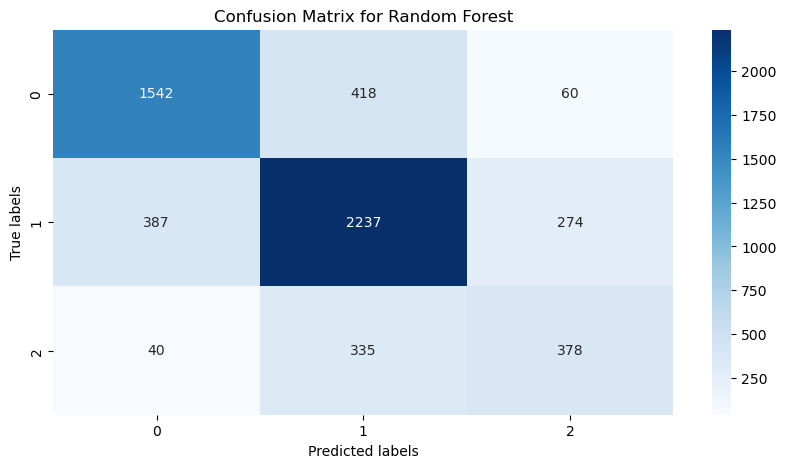

In [47]:
# confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(10, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Random Forest')

In [48]:
results.append(["Random Forest", accuracy_rf, f1_rf, training_duration])

### Gradient Boosting
<a id="gradient"></a>

We explore the use of another ensemble method, boosting, to see if this approach yields a better result than the Random Forest. We use `GridSearchCV()` once again to determine the best hyperparameters for the `GradientBoostingClassifier()` function.

In [52]:
start_time = time.time()

param_grid_gradient_boosting = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [5,10],
    'model__learning_rate': [0.01, 0.1],
    'model__criterion': ['friedman_mse', 'squared_error']   
    # no loss because exponential loss is not supported for multiclass classification
}

model = GradientBoostingClassifier(loss="log_loss", random_state=42)

pipeline_gradient = Pipeline([
    ('feature_engineering', FeatureEngineeringTransformer()),
    # ('resampler', resampler), # no resampling needed for GradientBoosting
    ('model', model)
])

grid_search_gb = GridSearchCV(
    estimator=pipeline_gradient,
    param_grid=param_grid_gradient_boosting,
    scoring='f1_macro',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

grid_search_gb.fit(X_train, y_train)
end_time = time.time()
training_duration = end_time - start_time
print(f"Total training time: {training_duration:.2f} seconds")

print("Best Parameters for GradientBoosting:", grid_search_rf.best_params_)
print("Best F1 Macro Score for GradientBoosting:", grid_search_rf.best_score_)


best_gb = grid_search_gb.best_estimator_
y_pred_gb= best_gb.predict(X_test)
print("\nClassification Report for GradientBoosting:")
print(classification_report(y_test, y_pred_gb))

accuracy_gb = accuracy_score(y_test, y_pred_gb)

f1_gb = f1_score(y_test, y_pred_gb,  average='macro')
print("F1 score:", f1_gb)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
Total training time: 584.53 seconds
Best Parameters for GradientBoosting: {'model__class_weight': None, 'model__max_depth': None, 'model__min_samples_leaf': 2, 'model__min_samples_split': 5, 'model__n_estimators': 100}
Best F1 Macro Score for GradientBoosting: 0.6853998102675992

Classification Report for GradientBoosting:
              precision    recall  f1-score   support

           0       0.80      0.75      0.78      2020
           1       0.73      0.86      0.79      2898
           2       0.78      0.42      0.54       753

    accuracy                           0.76      5671
   macro avg       0.77      0.68      0.70      5671
weighted avg       0.77      0.76      0.75      5671

F1 score: 0.7044050155754916


When using Gradient Boosting, the resulting model has a test accuracy of 74.1% which is an improvement from both the Decision Tree with fine-tuned hyperparameters and the Random Forest. The macro average F-1 score is 0.7, which also an improvement from the prior models.

Looking at the Confusion Matrix, we see that, similarly to the Random Forest model, the Gradient Boosting model predicted the correct label more times than not across all categories. In category 0, the F1 score was 0.78. In category 1, this number was 0.76, and in category 2 this was 0.55. We can see that once again there was a similar performance for categories 0 and 1, with a poorer performance for category 2. Compared to the Random Forest model, the F1 scores improved across all the categories. 

Although this Gradient Boosting model performs has a lower accuracy for predicting category 2 songs than the Random Forest, it has a higher F1 score. This suggests that although the Gradient Boosting model had fewer correct classifications, it did a better job at avoiding false positives and false negatives. Therefore, the improved F1 score indicates it was better at identifying true instances of category 2 songs.  

Despite fine-tuning the hyperparameters and using different models, the nuances in category 1 hit songs are difficult to predict. This is the biggest challenge at increasing the model's overall accuracy.

Text(0.5, 1.0, 'Confusion Matrix for Gradient Boosting')

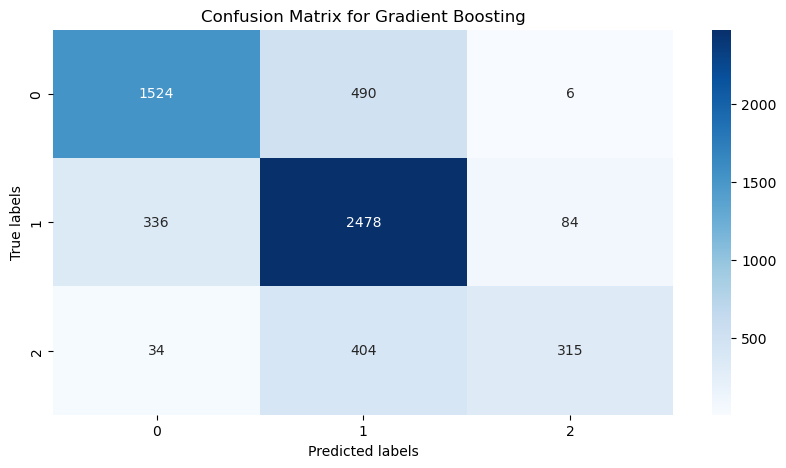

In [54]:
# confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_gb)
plt.figure(figsize=(10, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Gradient Boosting')

In [55]:
results.append(["Gradient Boosting", accuracy_gb, f1_gb, training_duration])   

### XGBoost
<a id="xgb"></a>

We also consider XGBoost to see if the model performance improves any further. We use `GridSearchCV()` to determine the best hyperparameters for `XGBClassifier()`.

In [57]:
start_time = time.time()
param_grid_xgb = {
    'model__n_estimators': [250,300,400],
    'model__max_depth': [None,5,10,],
    'model__learning_rate': [ 0.1,0.5],
    'model__subsample': [0.5,0.7, 1.0],
    'model__colsample_bytree': [0.5,0.7, 1.0],
}


model = XGBClassifier(eval_metric='mlogloss', random_state=42)

pipeline_xgb = Pipeline([
    ('feature_engineering', FeatureEngineeringTransformer()),
    # ('resampler', resampler), # no resampling needed for XGBoost
    ('model', model)
])
grid_search_xgb = GridSearchCV(
    estimator=pipeline_xgb,
    param_grid=param_grid_xgb,
    scoring='f1_macro',
    cv=cv,
    n_jobs=-1,
    verbose=1
)


grid_search_xgb.fit(X_train, y_train)
end_time = time.time()
training_duration = end_time - start_time
print(f"Total training time: {training_duration:.2f} seconds")

print("Best Parameters for XGBoost:", grid_search_xgb.best_params_)
print("Best F1 Macro Score for XGBoost:", grid_search_xgb.best_score_)

best_xgb = grid_search_xgb.best_estimator_
y_pred_xgb = best_xgb.predict(X_test)
print("\nClassification Report for XGBoostClassifier:")
print(classification_report(y_test, y_pred_xgb))

f1_xgb = f1_score(y_test, y_pred_xgb, average='macro')
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print("Accuracy:", accuracy_xgb)
print("F1 score:", f1_xgb)

Fitting 3 folds for each of 162 candidates, totalling 486 fits


/Users/Charlotte/micromamba/envs/cs109a/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Total training time: 245.95 seconds
Best Parameters for XGBoost: {'model__colsample_bytree': 0.7, 'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__n_estimators': 250, 'model__subsample': 1.0}
Best F1 Macro Score for XGBoost: 0.7038746677736594

Classification Report for XGBoostClassifier:
              precision    recall  f1-score   support

           0       0.80      0.76      0.78      2020
           1       0.74      0.85      0.79      2898
           2       0.77      0.43      0.55       753

    accuracy                           0.76      5671
   macro avg       0.77      0.68      0.71      5671
weighted avg       0.77      0.76      0.75      5671

Accuracy: 0.7621230823487921
F1 score: 0.7067094280119631


As we can see from the outputs, using XGBoost does not appear to offer any advantages over Gradient Boosting. The F1 scores are slightly decreased, and the accuracy is almost the same. Therefore, we decide to use the Gradient Boosting model. 

Text(0.5, 1.0, 'Confusion Matrix for XGBoost')

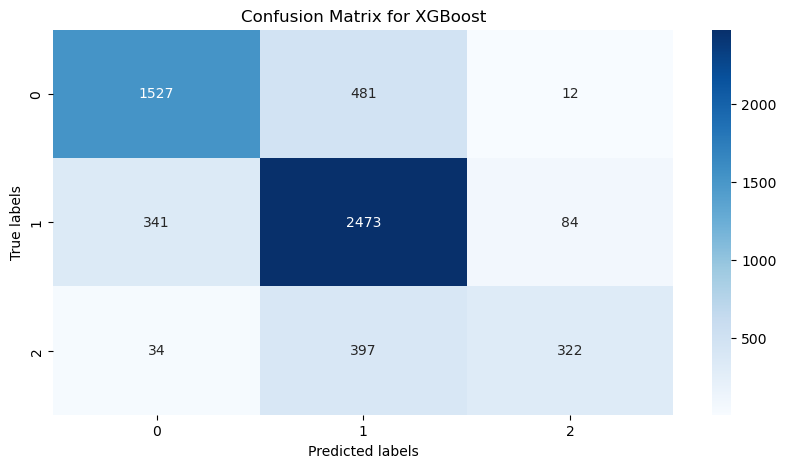

In [58]:
# confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(10, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for XGBoost')

In [59]:
results.append(["XGBoost", accuracy_xgb, f1_xgb, training_duration])

### Blending and Stacking
<a id="blendingstacking"></a>

We also considered Blending and Stacking as an alternative to see if it would offer any improvement to prior models. We used the XGBoost, Gradient Boosting and Decision Tree model in the Blended Model which we fit using the `VotingClassifier()` funcion. For the Stacked Model, we used the same base models, and a Logistic Regression meta model which was fit using the `StackingClassifier()` function.

In [61]:
start_time = time.time()
# remove "model__" prefix from best parameters if not it fails
xgb_params = {key.replace("model__", ""): value for key, value in grid_search_xgb.best_params_.items()}
gb_params = {key.replace("model__", ""): value for key,
             value in grid_search_gb.best_params_.items()}
dt_params = {key.replace("model__", ""): value for key,
             value in grid_search.best_params_.items()}

# models
xgb_model = XGBClassifier(
    eval_metric='mlogloss',
    random_state=42,
    **xgb_params
)
gradient_model = GradientBoostingClassifier(random_state=42, **gb_params)
decision_tree_model = DecisionTreeClassifier(random_state=42, **dt_params)

blended_model = VotingClassifier(
    estimators=[
        ('xgb', xgb_model),
        ('gradient', gradient_model),
        ('decision_tree', decision_tree_model),
    ],
    voting='hard'  
)

blended_model.fit(X_train, y_train)

end_time = time.time()
training_duration_blending = end_time - start_time

y_pred_blended = blended_model.predict(X_test)
print("\nClassification Report for Blended Model:")
print(classification_report(y_test, y_pred_blended))

accuracy_blended = accuracy_score(y_test, y_pred_blended)
print("Accuracy:", accuracy_blended)

f1_blended = f1_score(y_test, y_pred_blended, average='macro')
print("F1 Macro Score:", f1_blended)


Classification Report for Blended Model:
              precision    recall  f1-score   support

           0       0.80      0.76      0.78      2020
           1       0.74      0.86      0.79      2898
           2       0.79      0.41      0.54       753

    accuracy                           0.76      5671
   macro avg       0.78      0.67      0.70      5671
weighted avg       0.77      0.76      0.75      5671

Accuracy: 0.7626520895785576
F1 Macro Score: 0.703694584648606


We also fit a Blended Model to see if the performance would be better than the Gradient Boosting model. There is a slight improvement in the F1 score, although it still struggles with classifying songs in category 2. We also note that this model was trained using the Gradient Boosting and Decision Tree models that came before it. The improvement is marginal given the increase in complexity, so we decide to use the Gradient Boosting model.

In [62]:
start_time = time.time()
base_estimators = [
    ('xgb', xgb_model),
    ('gradient', gradient_model),
    ('decision_tree', decision_tree_model),
]

meta_model = LogisticRegression(random_state=42)

stacked_model = StackingClassifier(
    estimators=base_estimators,
    final_estimator=meta_model,
    cv=cv,  
    n_jobs=-1
)

stacked_model.fit(X_train, y_train)

end_time = time.time()
training_duration_stacking = end_time - start_time

y_pred_stacked = stacked_model.predict(X_test)
print("\nClassification Report for Stacked Model:")
print(classification_report(y_test, y_pred_stacked))

accuracy_stacked = accuracy_score(y_test, y_pred_stacked)
print("Accuracy:", accuracy_stacked)

f1_stacked = f1_score(y_test, y_pred_blended, average='macro')
print("F1 Macro Score:", f1_stacked)


Classification Report for Stacked Model:
              precision    recall  f1-score   support

           0       0.80      0.76      0.78      2020
           1       0.74      0.86      0.79      2898
           2       0.78      0.43      0.55       753

    accuracy                           0.76      5671
   macro avg       0.77      0.68      0.71      5671
weighted avg       0.77      0.76      0.76      5671

Accuracy: 0.763181096808323
F1 Macro Score: 0.703694584648606


Similarly to the Blended Model, the Stacked Model also resulted in a slight improvement in the F1 score, although the songs in category 2 still had by far the lowest F1 score. Like the Blended Model, the improvement in the Stacked Model is marginal given the increase in complexity, so we decide to use the Gradient Boosting model.

In [63]:
results.append(["Blended Model", accuracy_blended, f1_blended, training_duration_blending])
results.append(["Stacked Model", accuracy_stacked, f1_stacked, training_duration_stacking])

## Results
<a id="results"></a>

We compare the results of each of the different models.

In [64]:
print("Results:")
results_df = pd.DataFrame(results, columns=["Model", "Accuracy", "F1 score", "Training Duration (s)"])
results_df

Results:


,Model,Accuracy,F1 score,Training Duration (s)
0,Decision Tree,0.747664,0.694790,32.203768
1,Random Forest,0.733028,0.683006,133.998024
2,Gradient Boosting,0.761241,0.704405,584.527648
3,XGBoost,0.762123,0.706709,245.953937
4,Blended Model,0.762652,0.703695,30.224484
5,Stacked Model,0.763181,0.703695,49.615570


Like we discussed above, the Gradient Boosting model has the best F1 and accuracy scores (without Stacked model) after testing numerous models and hyperparameters. In particular, it does the best compared to the other models at identifying instances false positives and false negatives which are both important in this context. **We note that the Gradient Boosting model with an F1 score of 0.7 offers an improvement compared to our baseline Decision Tree model** which had an F1 score of 0.68. 

Despite efforts to increase the accuracy of predicting category 2 (the most popular songs) such as utilizing different models and using SMOTE as part of the pipeline to address the data imbalance, the model still struggled the most with predicting which songs would be hits. Nonetheless, the model performed better at differentiating songs in categories 0 and 1.

It therefore seems that, from our analysis, there are certain features or traits of songs that make some more popular than others although it is challenging to differentiate between neighbouring categories. 

### Retraining Gradient Boosting on the whole dataset

Retraining the chosen Gradient Boosting model using the optimal hyperparameters chosen by GridSearchCV.

In [65]:
start_time = time.time()

# gradient boosting with optimal hyperparameters
model = GradientBoostingClassifier(random_state=42, **gb_params)

# fit on the all dataset
model.fit(X_0mean, y_0mean)
end_time = time.time()
training_duration = end_time - start_time
print(f"Total training time: {training_duration:.2f} seconds")

Total training time: 35.23 seconds


#### Feature importance
<a id="featureimportance"></a>

From the permutation plot below, we can analyze the most important features in our chosen model. By far the most important factor is the Artist themself. This is not surprising, as once an artist gains a following and becomes recognized, their subsequent tracks are more likely to be anticipated and listened to by consumers. For a lot of big artists such a Taylor Swift, newly released music becomes popular in an instant, even if the style of their new music deviates slightly from existing work. This also suggests that it may be hard for new artists to "break in", and that generating a consistent audience is important. This hypothesis is backed up by the number of zero popularity score tracks on the platform which could be attributed to artists trying to find an audience.

Genre also appears to play a role in permutation importance - by its name, it's not surprising that pop has the most popular songs. It could be the case that some genres are more approachable and wide reaching than others.

We note that `release_year` is also an important feature. Trends in music are always changing, and what is popular changes with time. This feature being important suggests that when the song was released is relevant to how popular a certain song is today.

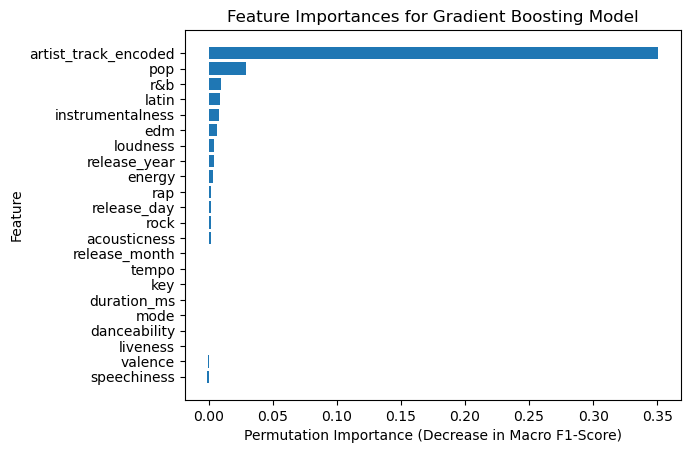

In [66]:
perm_importance = permutation_importance(best_gb, X_test, y_test, scoring='f1_macro', n_repeats=10, random_state=42)

sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(X_test.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance (Decrease in Macro F1-Score)")
plt.ylabel("Feature")
plt.title("Feature Importances for Gradient Boosting Model")
plt.show()

### Limitations and future directions
<a id="limitations"></a>

It is easier than ever to upload your own music, as well as to find new artists who may not be as popular in the mainstream. Although there are certain artists who are still the most popular, the music industry in many ways seems to be moving towards personalized recommendations. Even 10 years ago, the idea of a top chart and listening to the most popular songs was very common. Now, consumers are choosing platforms such as Spotify which are able to generate extremely personalized algorithms. 

Although identifying a song's popularity is an important task, analyzing music in this way has the limitation of not accounting for personal preferences. There may be trends in this variation across regions and countries, but ultimately it may come down to personal preference. It may be the case that trying to predict the most popular songs overall is too broad of a task. Perhaps it might make sense to look within certain geographies or music genres. This approach may make better sense from a music data perspective as songs from the same genre might share similarities, but also from an industry and consumer point of view. Industries can promote music in a more targeted manner to consumers.  

Furthermore, the dataset that our algorithm was trained on was using Spotify data, which captures a fraction of the demographic who listen to music. It may be the case that users in different countries or groups prefer using different streaming services, or even prefer to buy music. This means that there may be some data about music popularity that is not captured in the Spotify dataset. In the future, we could consider using data from additional sources. 

In practice, Spotify's algorithm - which uses the same metrics that we used in our analysis - is used for recommending songs and helping customers identify songs that they might enjoy. Like identifying popular music, connecting music to listeners is important for both industry and consumers, but does so in a different way. It may be the case that the metrics identified for Spotify's algorithm are more suited to recommendation algorithms that necessarily predicting popularity. Future work in this area could be to analyze music more closely, and to potentially identify metadata that would be more useful to prediction tasks. In the final part of our project, we will create our own version of a recommendation algorithm.

## Recommendation system
<a id="recommendation"></a>

For the 209A commponent of our project, we implemented a song recommendation system. Based on an inputted array of songs (i.e songs that the user likes), the system recommends other songs that are similar. While the most popular songs have historically been - and still are - important to industry, there has been a trend towards personalization. One of the draws of Spotify as a platform where we got our data from is that it provides very personalized playlists and song recommendations. 

We will implement this recommendation system using two different clustering methods - K-means and content-based filtering - and comparing their performances. 

In [67]:
# fresh start (we don't need our previous preprocessing steps)
file_path = '../data/processed_spotify_songs.csv'
data = pd.read_csv(file_path)

### K-Means clustering
<a id="kmeans"></a>

We firstly explore K-Means clustering. K-Means clustering groups songs clusters based on feature similarity (e.g., tempo, energy, and valence, and recommends recommendations songs from the same cluster as the user's input.

We select and scale the features that we choose to use for clustering. It is important to include features that represent song characteristics to ensure that songs are accurately grouped together. We normalize the features to ensure that variables that are measured in different ranges are treated as being equally important. 

In [68]:
cluster_features = [
    'danceability', 'energy', 'key', 'loudness', 'speechiness',
    'acousticness', 'instrumentalness', 'liveness', 'valence',
    'tempo', 'artist_track_encoded', 'release_year', 'edm', 'r&b', 'rap', 'latin', 'pop', 'rock'
]

scaler = StandardScaler()
normalized_features = scaler.fit_transform(data[cluster_features])

We  start by using the elbow method to find the optimal number of clusters. A lower intertia suggests better clustering, however we do not want to add too many clusters as doing could begin capturing the noise in the data, resulting in a model that may be less generalizable. While selecting too few clusters may result in groupings that are too broad for the song recommendations to be meaningful, selecting too many clusters could mean that some of the groupings are too narrow to find meaningful recommendations.

From the plot below, we decide to select an optimal k of 6. Past this point, the improvement in decrease in intertia are smaller for each additional cluster, and we want to avoid including too many clusters in our model.

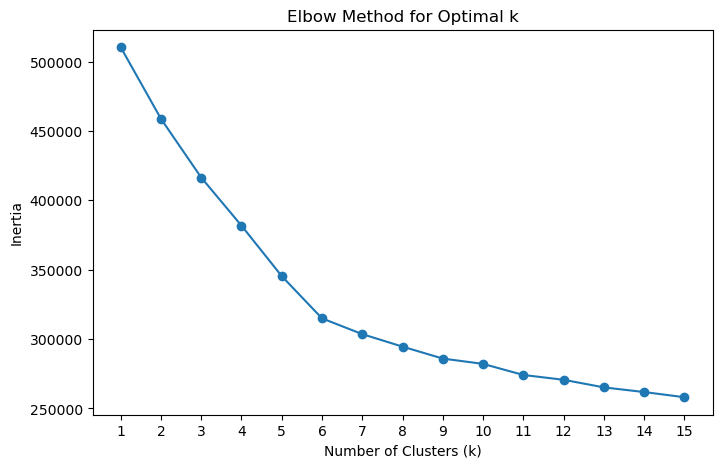

In [69]:
# Implementing the elbow method to find the optimal number of clusters
inertias = []
max_k = 15

for k in range(1, max_k + 1):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(normalized_features)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(range(1, max_k + 1), inertias, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.xticks(range(1, max_k + 1))
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

When visualize these clusters below in 3D using PCA where the clusters are represented along the first three principal components. This allows us to see the underlying structure an grouping of the data. We plot the PCA plot coloured by both the clusters and the musical genres, as we hypothesize that there is similarity between the two.

When comparing the PCA plot coloured by clusters to that coloured by genre from numerous angles, we notice that there is a lot of similarity. We can see this visually through the spatial distribution of the clusters, as well as from the cluster and genre boundaries (eg. the green sections align in shape and location when grouped by cluster and colour).

It therefore appears that the clusters formed by K-Means clustering are most likely to be based off of genre. This may be due to the fact that different genres share musical attributes and songs within each genre are more similar to each other.

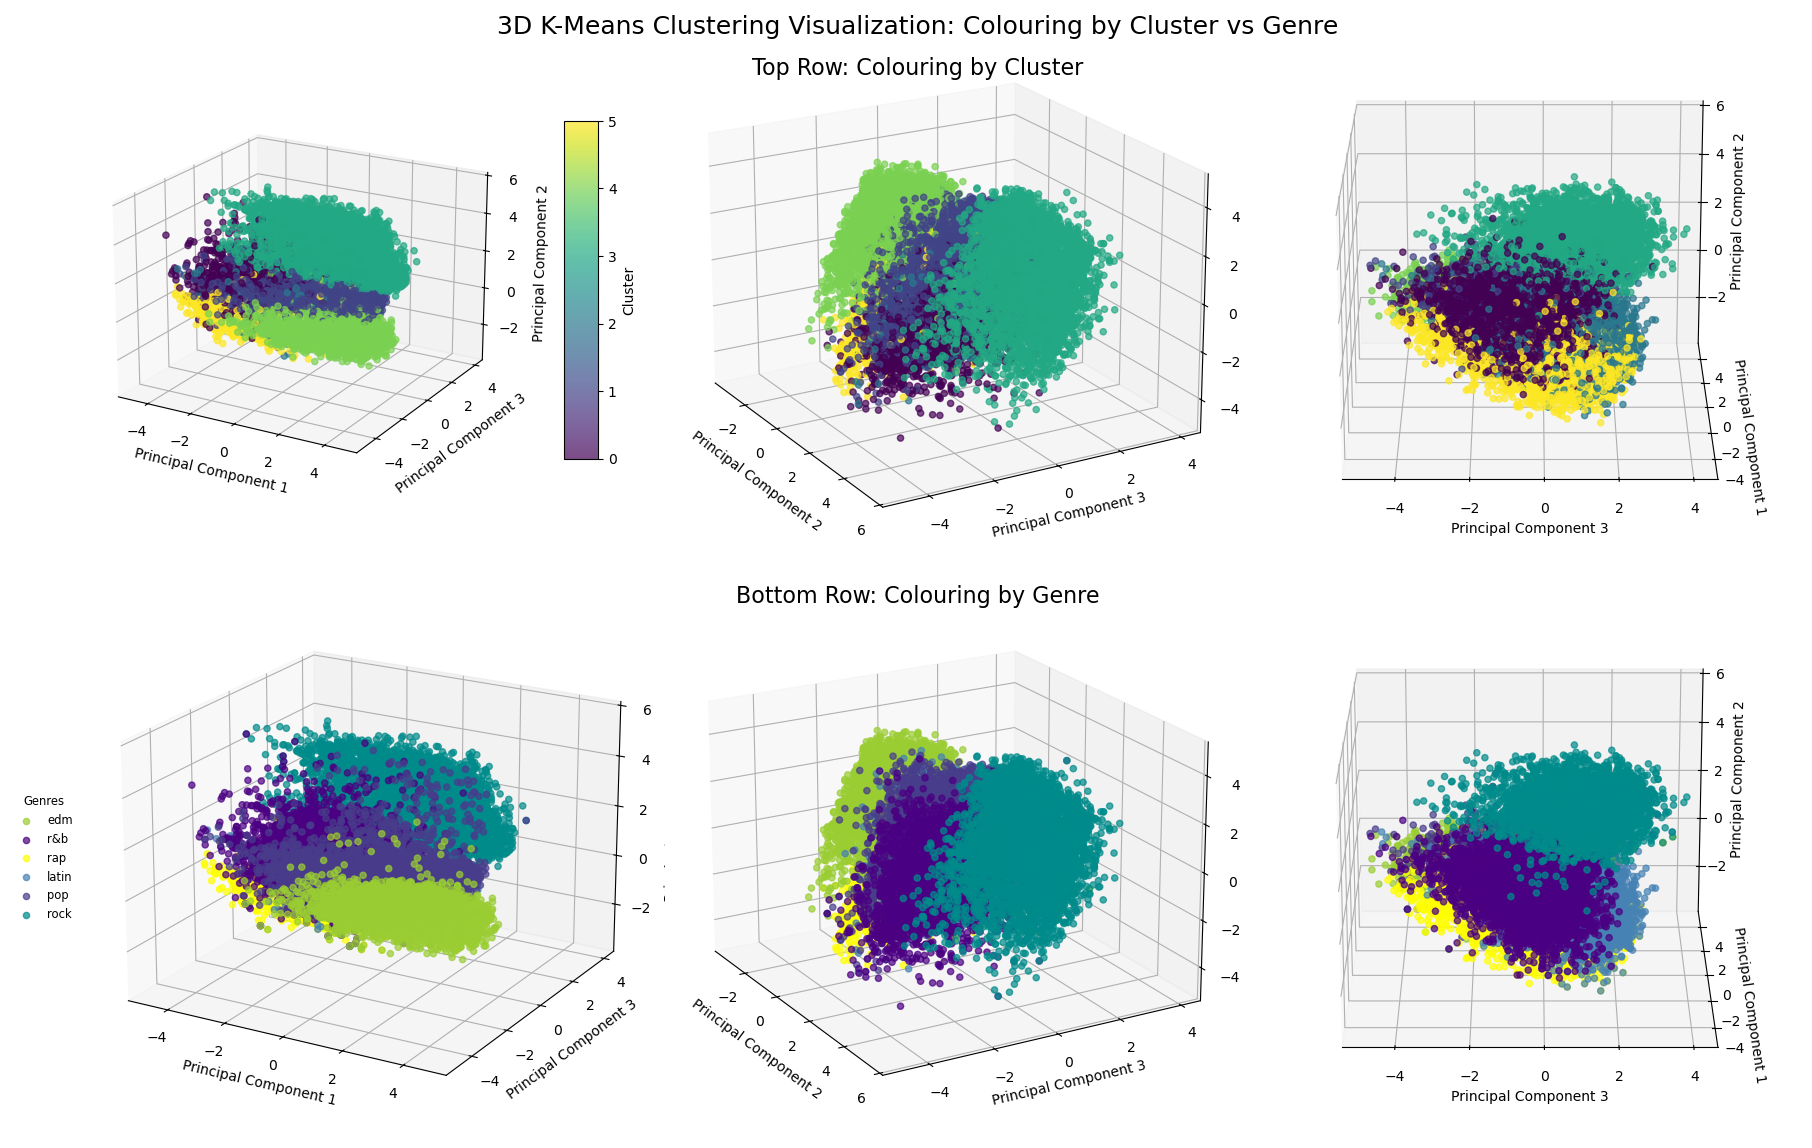

In [70]:
optimal_k = 6
genres = ['edm', 'r&b', 'rap', 'latin', 'pop', 'rock']
colors = ['yellowgreen', 'indigo', 'yellow', 'steelblue', 'darkslateblue', 'darkcyan']

# KMeans and PCA setup
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
data_cluster = data.copy()
data_cluster['Cluster'] = kmeans.fit_predict(normalized_features)

pca = PCA(n_components=3)
reduced_features = pca.fit_transform(normalized_features)

fig = plt.figure(figsize=(18, 12))

# define each angle for the plots (cluster and genre)
plots = [
    (0, 2, 1),  # coloured by cluster
    (1, 2, 0),  # coloured by cluster
    (2, 0, 1),  # coloured by cluster
    (0, 2, 1),  # coloured by genres
    (1, 2, 0),  # coloured by genres
    (2, 0, 1)   # coloured by genres
]

# add rotations to align viewing angles
view_angles = [
    (20, -60), 
    (20, -30), 
    (20, -90), 
    (20, -60),  # Bottom row angle (matching 3 top rows)
    (20, -30),  
    (20, -90)   
]

fig.suptitle("3D K-Means Clustering Visualization: Colouring by Cluster vs Genre", fontsize=18, y=0.95)
fig.text(0.5, 0.9, "Top Row: Colouring by Cluster", fontsize=16, ha='center')
fig.text(0.5, 0.46, "Bottom Row: Colouring by Genre", fontsize=16, ha='center')

for i, (x, y, z) in enumerate(plots, start=1):
    ax = fig.add_subplot(2, 3, i, projection='3d')

    # apply rotations using view_angles
    ax.view_init(elev=view_angles[i-1][0], azim=view_angles[i-1][1])
    
    if i <= 3:  # colored by clusters
        scatter = ax.scatter(
            reduced_features[:, x],
            reduced_features[:, y],
            reduced_features[:, z],
            c=data_cluster['Cluster'], cmap='viridis', alpha=0.7
        )
        if i == 1: # add legend for top row
            cbar = fig.colorbar(scatter, ax=ax, label='Cluster', shrink=0.6, aspect=10, pad=0.1)

    else:  # colored by genres
        for genre, color in zip(genres, colors):
            genre_data = data_cluster[data_cluster[genre] == 1]
            ax.scatter(
                reduced_features[genre_data.index, x],
                reduced_features[genre_data.index, y],
                reduced_features[genre_data.index, z],
                label=genre,
                color=color,
                alpha=0.7
            )
        if i == 4:  # add genre legend for bottom row
            ax.legend(
                title="Genres",
                loc='center left',
                bbox_to_anchor=(-0.15, 0.5),
                fontsize='small',
                title_fontsize='small',
                frameon=False
            )
    
    ax.set_xlabel(f'Principal Component {x + 1}')
    ax.set_ylabel(f'Principal Component {y + 1}')
    ax.set_zlabel(f'Principal Component {z + 1}')

plt.tight_layout()
plt.show()


We now define a recommendation function that takes uses these clusters to recommend songs.

Using various inputs and outputs from this function, we can more rigorously analyze which features the recommendation model focuses on the most.

In [71]:
def recommend_songs_k_means(input_indices, data_cluster, normalized_features, num_recommendations=1):

    cluster_features = data_cluster['Cluster'].values.reshape(-1, 1)
    combined_features = np.hstack([normalized_features, cluster_features])

    input_song_features = combined_features[input_indices]

    similarities = cosine_similarity(input_song_features, combined_features)
    similarities = np.mean(similarities, axis=0)

    for idx in input_indices:   
        similarities[idx] = -1
        
    recommended_song_indices = np.argsort(similarities)[::-1][:num_recommendations]

    return data_cluster.iloc[recommended_song_indices]

We also define a function that will allow us to visualize the characteristics of the input songs compared to that of the output songs using a radar chart. It uses the values of the normalized features for both the input songs and the recommended songs. It can therefore be used to see if there is any different in ouput for each of the the K-Means and content-based filtering algorithms.

In [72]:
def plot_radar_chart(input_indices, recommended_indices, data, features):
    # mean feature values for input and recommended songs (in case multiple input / output)
    input_means = data.iloc[input_indices][features].mean().values
    recommended_means = data.iloc[[recommended_indices]][features].mean().values  # Fix here
    
    labels = np.array(features)
    num_vars = len(features)
    
    # plot shape
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1] 
    
    input_means = np.concatenate((input_means, [input_means[0]]))
    recommended_means = np.concatenate((recommended_means, [recommended_means[0]]))
    
    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
    ax.fill(angles, input_means, color='red', alpha=0.25, label='Input Songs')
    ax.plot(angles, input_means, color='red', linewidth=2)
    
    ax.fill(angles, recommended_means, color='blue', alpha=0.25, label='Recommended Songs')
    ax.plot(angles, recommended_means, color='blue', linewidth=2)
    
    ax.set_yticklabels([])
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels, fontsize=10)
    plt.title('Feature Comparison: Input vs Recommended Songs')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2, fontsize=10)
    plt.show()

features_plot = ['tempo', 'energy', 'valence', 'danceability', 'speechiness', 'liveness', 'loudness', 'acousticness', 'instrumentalness']

In [73]:
### If we input 3 songs from the same artist, we might get songs from the same artist
input_indices = [1048, 1049, 27747]
print("Input test 1: 3 songs from the same artist")
print(data_cluster.iloc[input_indices][['track_artist', 'playlist_subgenre', 'release_year', 'edm', 'r&b', 'rap', 'latin', 'pop', 'rock', 'Cluster']])
recommendations = recommend_songs_k_means(input_indices, data_cluster, normalized_features)
print("Output 1: Recommended Song:")
print(recommendations[['track_artist', 'playlist_subgenre', 'release_year', 'edm', 'r&b', 'rap', 'latin', 'pop', 'rock', 'Cluster']])

Input test 1: 3 songs from the same artist
        track_artist          playlist_subgenre  release_year  edm  r&b  rap  \
1048   Martin Garrix              electro house          2014    1    0    0   
1049   Martin Garrix  progressive electro house          2016    1    0    0   
27747  Martin Garrix              electro house          2017    1    0    0   

       latin  pop  rock  Cluster  
1048       0    0     0        4  
1049       0    0     0        4  
27747      0    0     0        4  
Output 1: Recommended Song:
      track_artist playlist_subgenre  release_year  edm  r&b  rap  latin  pop  \
24287        Audax     electro house          2019    1    0    0      0    0   

       rock  Cluster  
24287     0        4  


From this first output, we can see that recommending three songs from the same artist (in this case Martin Garrix) does not result in the model recommending another song from Martin Garrix as we might expect. The outputted song belongs to the same cluster, genre (edm), subgenre as the inputted songs. 

This is behaviour is not necessarily unwanted a recommendation system as each artist has a finite number of songs, and often fans of one artist may be looking for new artists that are similar, although it is different from we may expect.

In [74]:
### If we input 3 songs from the same playlist, we should get songs from the same playlist genre at least
input_indices = [388, 424, 830]
print("Input test 2: 3 songs from the same playlist")
print(data_cluster.iloc[input_indices][['track_artist', 'playlist_id', 'playlist_subgenre', 'release_year', 'edm', 'r&b', 'rap', 'latin', 'pop', 'rock', 'Cluster']])
recommendations = recommend_songs_k_means(input_indices, data_cluster, normalized_features)
print("Output: Recommended Song:")
print(recommendations[['track_artist', 'playlist_id', 'playlist_subgenre', 'release_year', 'edm', 'r&b', 'rap', 'latin', 'pop', 'rock', 'Cluster']])

Input test 2: 3 songs from the same playlist
    track_artist             playlist_id  playlist_subgenre  release_year  \
388      Finesse  37i9dQZF1DX0SM0LYsmbMT            hip hop          2020   
424        Kazam  37i9dQZF1DX0SM0LYsmbMT            hip hop          2019   
830    City Girl  37i9dQZF1DX0SM0LYsmbMT  hip hop, tropical          2018   

     edm  r&b  rap  latin  pop  rock  Cluster  
388    0    0    1      0    0     0        5  
424    0    0    1      0    0     0        5  
830    0    0    1      1    0     0        5  
Output: Recommended Song:
      track_artist             playlist_id playlist_subgenre  release_year  \
11878      Glimlip  37i9dQZF1DWWQRwui0ExPn           hip hop          2019   

       edm  r&b  rap  latin  pop  rock  Cluster  
11878    0    0    1      0    0     0        5  


In this second test, we can see that recommending three songs with the same `playlist_id` (but different artists) does not result in the model recommending another song from the exact same playlist. The outputted song belongs to the same cluster, genre (rap), subgenre as the inputted songs. 

In [75]:
### If we input 3 songs from the same subgenre, we should get songs from the same subgenre (at least genre)
input_indices = [1, 6, 38]
print("Input test 3: 3 songs from the same subgenre")
print(data_cluster.iloc[input_indices][['track_artist', 'playlist_subgenre', 'release_year', 'edm', 'r&b', 'rap', 'latin', 'pop', 'rock', 'Cluster']])
recommendations = recommend_songs_k_means(input_indices, data_cluster, normalized_features)
print("Output: Recommended Song:")
print(recommendations[['track_artist', 'playlist_subgenre', 'release_year', 'edm', 'r&b', 'rap', 'latin', 'pop', 'rock', 'Cluster']])

Input test 3: 3 songs from the same subgenre
   track_artist playlist_subgenre  release_year  edm  r&b  rap  latin  pop  \
1          RIKA          neo soul          2018    0    1    0      0    0   
6     Christión          neo soul          1997    0    1    0      0    0   
38  CeeLo Green          neo soul          2012    0    1    0      0    0   

    rock  Cluster  
1      0        0  
6      0        0  
38     0        0  
Output: Recommended Song:
        track_artist playlist_subgenre  release_year  edm  r&b  rap  latin  \
18392  Luther Ingram          neo soul          2008    0    1    0      0   

       pop  rock  Cluster  
18392    0     0        0  


In this third test, we inputted 3 songs from the same subgenre (neosoul). In this case, we can see that the output recommends a song belonging to the same cluster, genre (r&b) and subgenre as the input. 

Across these three tests, we notice that the recommendation system focuses the most on recommending songs with the same genre and subgenre (as well as cluster). It is expected behaviour that the output returns a song in the same cluster, and we notice that this correlates with genre and subgenre. This corroborates our hypothesis that we visualized above that suggests that there is a lot of similarity between the clusters and the musical genres.

In this next test, we try to input songs that are not similar whatsoever (unlike in the previous three tests).

In [76]:
input_indices_random = np.random.choice(data_cluster.shape[0], 3, replace=False)
print("Test 4: inputting 3 random songs")
data_cluster.iloc[input_indices_random][['track_artist', 'playlist_subgenre', 'release_year', 'edm', 'r&b', 'rap', 'latin', 'pop', 'rock', 'Cluster']]

Test 4: inputting 3 random songs


,track_artist,playlist_subgenre,release_year,edm,r&b,rap,latin,pop,rock,Cluster
10890,LOOPERS,electro house,2019,1,0,0,0,0,0,4
4722,MOONZz,indie poptimism,2017,0,0,0,0,1,0,1
17903,J Balvin,latin hip hop,2018,0,0,0,1,0,0,2


In [77]:
recommendations = recommend_songs_k_means(input_indices_random, data_cluster, normalized_features)
print("Recommended Song:")
recommendations[['track_artist', 'playlist_subgenre', 'release_year', 'edm', 'r&b', 'rap', 'latin', 'pop', 'rock', 'Cluster']]

Recommended Song:


,track_artist,playlist_subgenre,release_year,edm,r&b,rap,latin,pop,rock,Cluster
6038,Lyre Le Temps,electro house,2016,1,0,0,0,0,0,4


Across numerous iterations of this test, we notice that the playlist subgenre, genre and cluster of the outputted song is the same as at least one of the inputted songs. When the random input contains two songs of the same genre, the recommendation system's output is a song in this same genre. Furthermore, even with the non-random tests, we notice that the release year of the song is also close to that on average of the input songs.

We can visualize the difference between the features of the input and output songs through the radar chart below. As we can see, there is significant overlap between the average of the features of the input songs and the output song.

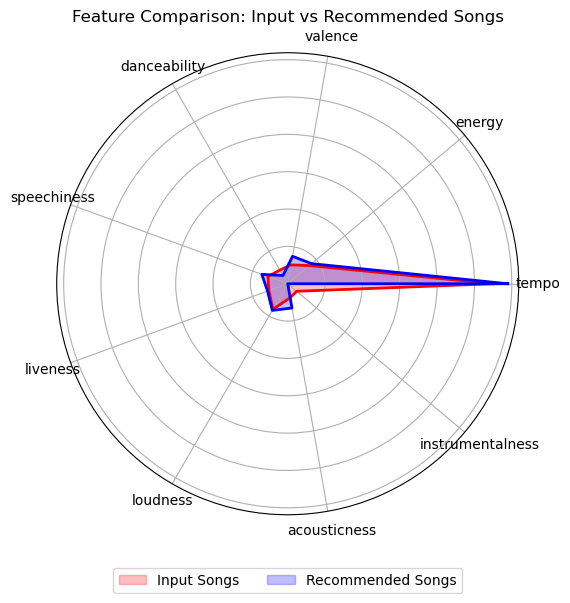

In [78]:
plot_radar_chart(input_indices_random, recommendations.index[0], data_cluster, features_plot)

### Content-based filtering
<a id="content"></a>

Next, we will implement content-based filtering to see how it compares to the K-Means clustering above. While K-Means groups clusters by Euclidean distance and our implementation suggested songs based on these groupings, content-based filtering utilizes cosine similarity to directly compare songs to a user's inputted preferences.

We start by selecting the features we want to influence the recommend system. We include features that represent song characteristics to ensure that there is enough information to group songs together accurately.

In [79]:
# The features we want to influence the recommendation system
features = [
        'danceability', 'energy', 'key', 'loudness', 'speechiness',
        'acousticness', 'instrumentalness', 'liveness', 'valence',
        'tempo', 'artist_track_encoded', 'release_year', 'edm', 'r&b', 'rap', 'latin', 'pop', 'rock'
    ]

In [80]:
def recommend_songs_content_filter(input_indices, data, features, num_recommendations=1):
    feature_matrix = data[features].values
    input_features = feature_matrix[input_indices]
    avg_features = np.mean(input_features, axis=0).reshape(1, -1)
    
    similarities = cosine_similarity(avg_features, feature_matrix).flatten()
    similar_indices = np.argsort(similarities)[::-1]
    similar_indices = [idx for idx in similar_indices if idx not in input_indices][:num_recommendations]
    
    return data.iloc[similar_indices]

Like with the K-Means model, we will now perform the same type of analysis looking at the system input versus output. In order to best compare our two models, we decided to use the same songs for these tests as for the K-Means tests.

In [81]:
### 3 songs from the same artist
input_indices = [1048, 1049, 27747]
print("Input test 1: 3 songs from the same artist")
print(data_cluster.iloc[input_indices][['track_artist', 'playlist_subgenre', 'release_year', 'edm', 'r&b', 'rap', 'latin', 'pop', 'rock', 'Cluster']])
recommendations = recommend_songs_content_filter(input_indices, data, features)
print("Recommended Songs:")
print(recommendations[['track_artist', 'playlist_subgenre', 'release_year', 'edm', 'r&b', 'rap', 'latin', 'pop', 'rock', 'Cluster']])

Input test 1: 3 songs from the same artist
        track_artist          playlist_subgenre  release_year  edm  r&b  rap  \
1048   Martin Garrix              electro house          2014    1    0    0   
1049   Martin Garrix  progressive electro house          2016    1    0    0   
27747  Martin Garrix              electro house          2017    1    0    0   

       latin  pop  rock  Cluster  
1048       0    0     0        4  
1049       0    0     0        4  
27747      0    0     0        4  
Recommended Songs:
        track_artist                         playlist_subgenre  release_year  \
13723  Martin Garrix  electro house, progressive electro house          2014   

       edm  r&b  rap  latin  pop  rock  Cluster  
13723    1    0    0      0    0     0        1  


The output suggested a song with the same artist and genre (edm), but different playlist subgenres. Notably, the recommended song also belongs to a different cluster than the inputted songs. This differs slightly from the output of the K-Means algorithm which returned a song with the same genre, cluster and subgenre. While the K-Means algorithm relied on the clusters to recommend songs, we can see that the content-based filtering relies on other characteristics. 

In [82]:
### Input 3 songs from the same playlist
input_indices = [388, 424, 830]
print("Input test 2: 3 songs from the same playlist")
print("Some of the input songs' features:")
print(data_cluster.iloc[input_indices][['track_artist', 'playlist_id', 'playlist_subgenre', 'release_year', 'edm', 'r&b', 'rap', 'latin', 'pop', 'rock', 'Cluster']])
recommendations = recommend_songs_content_filter(input_indices, data, features)
print("Recommended Songs:")
print(recommendations[['track_artist', 'playlist_id', 'playlist_subgenre', 'release_year', 'edm', 'r&b', 'rap', 'latin', 'pop', 'rock', 'Cluster']])

Input test 2: 3 songs from the same playlist
Some of the input songs' features:
    track_artist             playlist_id  playlist_subgenre  release_year  \
388      Finesse  37i9dQZF1DX0SM0LYsmbMT            hip hop          2020   
424        Kazam  37i9dQZF1DX0SM0LYsmbMT            hip hop          2019   
830    City Girl  37i9dQZF1DX0SM0LYsmbMT  hip hop, tropical          2018   

     edm  r&b  rap  latin  pop  rock  Cluster  
388    0    0    1      0    0     0        5  
424    0    0    1      0    0     0        5  
830    0    0    1      1    0     0        5  
Recommended Songs:
      track_artist             playlist_id playlist_subgenre  release_year  \
23482     Guustavv  37i9dQZF1DWWQRwui0ExPn           hip hop          2019   

       edm  r&b  rap  latin  pop  rock  Cluster  
23482    0    0    1      0    0     0        1  


Inputting 3 songs from the same playlist resulted in an output from a different playlist. However, we can see that the recommended song belongs to the same genre (rap) and subgenres, and has a similar release year to the original songs. We note that for in this test, the cluster also differs between the input songs and the output song.

In [83]:
### If we input 3 songs from the same subgenre, we should get songs from the same subgenre (or at least genre)
input_indices = [1, 6, 38]
print("Input test 3: 3 songs from the same subgenre")
print(data_cluster.iloc[input_indices][['track_artist', 'playlist_subgenre', 'release_year', 'edm', 'r&b', 'rap', 'latin', 'pop', 'rock', 'Cluster']])
recommendations = recommend_songs_content_filter(input_indices, data, features)
print("Recommended Song:")
print(recommendations[['track_artist', 'playlist_subgenre', 'release_year', 'edm', 'r&b', 'rap', 'latin', 'pop', 'rock', 'Cluster']])

Input test 3: 3 songs from the same subgenre
   track_artist playlist_subgenre  release_year  edm  r&b  rap  latin  pop  \
1          RIKA          neo soul          2018    0    1    0      0    0   
6     Christión          neo soul          1997    0    1    0      0    0   
38  CeeLo Green          neo soul          2012    0    1    0      0    0   

    rock  Cluster  
1      0        0  
6      0        0  
38     0        0  
Recommended Song:
     track_artist playlist_subgenre  release_year  edm  r&b  rap  latin  pop  \
9810  Keith Sweat    new jack swing          2015    0    1    0      0    0   

      rock  Cluster  
9810     0        0  


In this third test, we inputted 3 songs from the same subgenre (neosoul). We would expect that the output to also be from this same subgenre like in the K-Means Clustering algorithm, however we see that this is not the case. The recommended song belongs to the same genre (r&b) and cluster.

Across the three tests, we notice that the content-based filtering returns different recommendations than the K-Means clustering. In the first test where the inputted songs all belonged to same artist, this time the content-based filtering algorithm recommended a song with this same artist unlike the K-Means algorithm. However, in the second test where the inputted songs belonged to the same playlist, it did not recommend a song from the same playlist although the song had the same subgenre and genre which was a similar result to the K-Means equivalent. Surprisingly, for the third test where the three inputted songs belonged to the same subgenre, the content-based filtering algorithm did not recommend a song from this same subgenre although it did have the same genre.

Similarly to with the K-Means algorithm, we now try to input songs that are not similar whatsoever (unlike in the previous three tests). We use the same songs that were randomly generated for the K-Means algorithm.

In [84]:
print("Recall the input songs' features:")
data.iloc[input_indices_random][['track_artist', 'playlist_subgenre', 'release_year', 'edm', 'r&b', 'rap', 'latin', 'pop', 'rock']]

Recall the input songs' features:


,track_artist,playlist_subgenre,release_year,edm,r&b,rap,latin,pop,rock
10890,LOOPERS,electro house,2019,1,0,0,0,0,0
4722,MOONZz,indie poptimism,2017,0,0,0,0,1,0
17903,J Balvin,latin hip hop,2018,0,0,0,1,0,0


In [85]:
recommendations = recommend_songs_content_filter(input_indices_random, data, features)
print("Recommended Songs:")
recommendations[['track_artist', 'playlist_subgenre', 'release_year', 'edm', 'r&b', 'rap', 'latin', 'pop', 'rock']]

Recommended Songs:


,track_artist,playlist_subgenre,release_year,edm,r&b,rap,latin,pop,rock
19646,Chucho Rivas,latin pop,2019,0,0,0,1,0,0


Similarly to the results above, the content-based filtering algorithm did not recommend the same song as the K-Means. However across numerous iterations, the output consistently belong to the same genre as at least one of the inputted songs. Furthermore, the release year is comparable on average to the inputted songs.

The radar chart below also demonstrates that there is significfant overlap between the averaged features of the inputted songs and the recommended song.

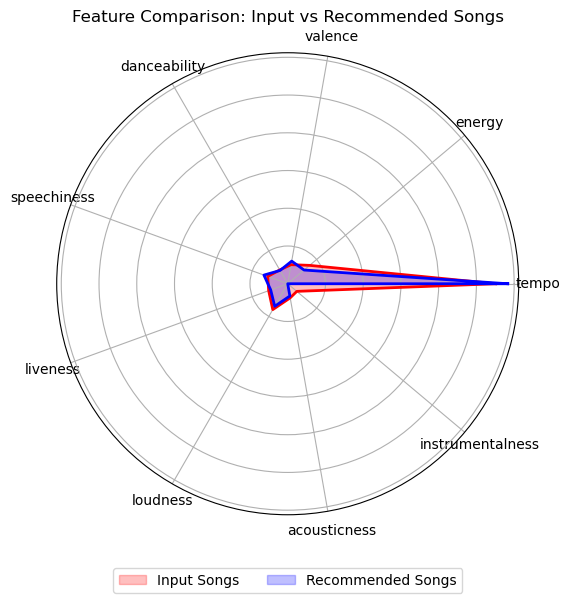

In [86]:
plot_radar_chart(input_indices_random, recommendations.index[0], data_cluster, features_plot)

### Analysis and Future Directions
<a id="analysis"></a>

From the analysis above, we see that K-Means and Content-based filtering are two different ways of recommending songs. While K-Means makes use of recommending songs in the same cluster, content-based filtering uses characteristics of a song the user already enjoys (and has inputted into the algorithm). 

It is challenging to evaluate how good these models are, and whether one is better than the other, because there is no base truth to whether a recommendation was good or not - this is subjective. While a recommendation may be good on paper or mathematically by the algorithm we choose, the user may not enjoy the song in practice.

One important future direction would be to consider user input and whether the suggested song is something the user actually enjoys. Receiving user feedback would be an important next step in further refining this algorithm. Furthermore, we note that users may not actually want songs that are exactly the same and may want to explore new genres. Gaining a better understanding of user habits (eg. users who like pop also like r&b) could help to improve recommendations. Ultimately, it may be hard to assess the quality of recommendations without user input given the subjectivity associated with recommendation systems.